# ARCH2

**Behavioral Analysis**

Load data into dataframe: Ratings then SSAT

Ratings reliability. M1 + ICC.

Paired-sample t-test for each rating: Rating ~ Condition. + plot



notes: 

**IMPORTANT:**
high facelike Houses numbers: 3,9,11,15,16,19,20,33,55,59,64,67,73,77,82,83,84,85,86,89
low facelike Houses numbers: 4,8,10,17,27,28,34,35,41,47,48,50,53,56,70,81,94,96,97,98

Fetch data from server: smb://mpib-berlin.mpg.de/LMG-EnvNeuro/Projects/ARCH_2/data/raw/beh

In [1]:
# Turn off warnings
defaultW <- getOption("warn") 
options(warn = -1) 
options(warn = defaultW)

# Analysis
library(ez)
#citation("ez")
library(emmeans)
#citation("emmeans")

# Plotting and formatting
library(cowplot)
library(dplyr)
library(readr) 
library(ggplot2)
library(lmerTest)
library(hrbrthemes)
library(sjPlot)
library(sjmisc)
library(sjlabelled)
# Raincloud plot( from https://github.com/RainCloudPlots/RainCloudPlots):
source('R_rainclouds.R')
library(tidyr)
library(tidyverse)
library(ggthemes)
library(ggpubr)
# Formatting
library(knitr)
library(jtools)
library(apaTables)
# Reliability
library(psych)
library(tidyr)
library(boot)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lme4

Warning message:
“package ‘lme4’ was built under R version 4.3.2”
Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 4.3.2”

Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step


NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.

      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and

      if Arial Narrow is not on your system, please see https://bit.ly/arialnarrow

Learn more about sjPlot with 'browseVignettes("sjPlot")'.


Attaching package: ‘sjPlot’


The following objects are masked from ‘package:cowplot’:

    plot_grid, save_plot



At

## Logistics

In [2]:
# ======================
# load data
# ======================
# root directory
root = '/Users/sztuka/Documents/ARCH2/data/behavioral/'
# for the output
figures = '/Users/sztuka/Documents/ARCH2/figures/'
tables = '/Users/sztuka/Documents/ARCH2/tables/'

# from the root directory, list all the directories and create a vector of the directory names
subjects = list.dirs(root, full.names = FALSE, recursive = FALSE)
# print the list of the subjects
print(subjects)
# count and print number of subjects
n_subjects = length(subjects)
print('Number of subjects:')
print(n_subjects)

# rating scales:

scales = c("Preference", "Naturalness", "Facelikeness", "ApAv", "Stress", "Relaxation")

 [1] "sub-0643EC" "sub-0XVVLW" "sub-0ZLEZL" "sub-1RL8ME" "sub-27TJLA"
 [6] "sub-2JGADF" "sub-2TDV2E" "sub-2YJQ81" "sub-5FKTYP" "sub-5LX3RV"
[11] "sub-5XEATU" "sub-692TA2" "sub-6ZNUMA" "sub-71YU0T" "sub-8833PM"
[16] "sub-9PHL2Y" "sub-D228RH" "sub-DUQC8H" "sub-ED6XWJ" "sub-F1UNYD"
[21] "sub-FQYHLW" "sub-G1D3ZH" "sub-H0DFAP" "sub-HGGN3N" "sub-HNA1HX"
[26] "sub-KLXEGK" "sub-LCL5PG" "sub-LV6AYV" "sub-MAF9NP" "sub-PE6KV7"
[31] "sub-Q4P2LK" "sub-QAF6NN" "sub-QAN8Y3" "sub-RTR2CN" "sub-RY291P"
[36] "sub-TZ3VPN" "sub-VFK94M" "sub-W54493" "sub-WCL82L" "sub-WRFLN5"
[41] "sub-WUK7GD" "sub-YXV5VF" "sub-Z1MUFD" "sub-ZWLDUK" "sub-ZXMM4V"
[1] "Number of subjects:"
[1] 45


## Functions

In [3]:
# ======================
# Functions
# ======================
# function to load the ratings from subject list

load_ratings = function(subjects){
  # create empty data frame
  ratings = data.frame()
  # loop through the subjects
  for (i in 1:length(subjects)){
    # load the data
    data = read.csv(paste0(root, subjects[i],'/ratings/',subjects[i],'_task_ratings.csv'))
    # add the subject id
    data$subject = subjects[i]
    # bind the data
    ratings = rbind(ratings, data)
  }
  return(ratings)
}

# function to load the SSAT from subject list

load_ssat = function(subjects){
  # create empty data frame
  ssat = data.frame()
  ssat_sum <- matrix(0, nrow = 40, ncol = 40)
  # loop through the subjects
  for (i in 1:length(subjects)){
    file_path <- paste0(root, subjects[i], '/ssat/', subjects[i], '_task_distances.csv')
    # load the data
    data = read.csv(file_path)
    # Load the data (assuming the file contains a 40x40 matrix without headers)
    distance_matrix <- as.matrix(data[,-1])
    # print(dim(distance_matrix))
    # Ensure the matrix is 40x40
    if (dim(distance_matrix)[1] != 40 || dim(distance_matrix)[2] != 40) {
      stop(paste("File", file_path, "does not contain a 40x40 matrix"))
    }
    # Add the distances to the cumulative sum matrix
    ssat_sum <- ssat_sum + distance_matrix

    # if needed the subject level data uncomment this:
    # add the subject id
    # data$subject = subjects[i]
    # bind the data
    # ssat = rbind(ssat, data)
  }
  return(ssat_sum)
}

# Function for half-split reliability with pivot
half_split_reliability_with_pivot <- function(ratings_df, scales) {
  # Initialize list to store reliabilities
  reliabilities <- list()
  
  for (scale in scales) {
    # Reshape the data for the current scale
    reshaped_data <- ratings_df %>%
      select(subject, House, all_of(scale)) %>%
      pivot_wider(names_from = House, values_from = all_of(scale)) %>%
      rename_with(~ paste0(scale, "_", .x), -subject)
    
    # Debugging: Print reshaped data for the scale
    cat("Reshaped data for scale:", scale, "\n")
    #print(head(reshaped_data))
    
    # Randomly split the columns (excluding 'subject')
    set.seed(123) # Ensure reproducibility
    col_indices <- sample(2:ncol(reshaped_data), size = floor((ncol(reshaped_data) - 1) / 2))
    half1 <- reshaped_data[, col_indices]
    half2 <- reshaped_data[, setdiff(2:ncol(reshaped_data), col_indices)]
    
    # Calculate row sums for each half
    half1_scores <- rowSums(half1, na.rm = TRUE)
    half2_scores <- rowSums(half2, na.rm = TRUE)
    
    # Compute correlation between halves
    r <- cor(half1_scores, half2_scores, use = "complete.obs")
    
    # Apply Spearman-Brown adjustment
    reliability <- if (!is.na(r) && r > -1) 2 * r / (1 + r) else NA
    
    # Store reliability for the scale
    reliabilities[[scale]] <- reliability
    
    # Print reliability for the current scale
    cat("Reliability for scale", scale, ":", reliability, "\n")
  }
  
  return(reliabilities)
}


# Core MM1 calculation
reshape_for_MM1 <- function(df, scale) {
  reshaped_data <- df %>%
      select(subject, Image, all_of(scale)) %>%
      pivot_wider(names_from = Image, values_from = all_of(scale)) %>%
      rename_with(~ paste0(scale, "_", .x), -subject)
  
  # Return the reshaped data
  return(reshaped_data)
}

MM1_core <- function(df, scale) {
  # Extract subject IDs and ratings
  id <- df$subject
  ratings <- df %>% select(-subject)
  
  # Convert all ratings to numeric
  ratings <- as.data.frame(lapply(ratings, as.numeric))

  # Compute means minus ones
  means <- matrix(nrow = nrow(ratings), ncol = ncol(ratings))
  for (i in 1:nrow(ratings)) {
    for (j in 1:ncol(ratings)) {
      means[i, j] <- mean(as.numeric(ratings[-i, j]), na.rm = TRUE)
    }
  }

  # Compute correlations between means minus ones and individual ratings
  mm1 <- c()
  for (i in 1:nrow(ratings)) {
    cor <- cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs")
    mm1 <- c(mm1, cor)
  }

  # Transform correlations into z-scores (Fisher's r-to-z transformation)
  zScores <- c()
  for (k in 1:length(mm1)) {
    if (!is.na(mm1[k]) && mm1[k] != 1 && mm1[k] != -1) {  # Ensure valid correlation values
      z <- 0.5 * log((1 + mm1[k]) / (1 - mm1[k]))
      zScores <- c(zScores, z)
    }
  }
  # Calculate average correlation (z average to r average Fisher)
  avg_corr <- (exp(2 * mean(zScores)) - 1) / (exp(2 * mean(zScores)) + 1)
  return(avg_corr)
}

MM1_with_CI <- function(df, scale, n_bootstrap = 1000) {
  # size of df
  # Bootstrap function
  bootstrap_function <- function(df, indices) {
    df_boot <- df[indices, ]
    MM1_core(df_boot, scale)
  }
  # Reshape data for the specified scale
  boot_results <- boot(data = df, statistic = bootstrap_function, R = n_bootstrap)

  # Calculate 95% CI
  CI <- boot.ci(boot_results, type = "perc")$percent[4:5]

  # Original MM1 score calculation
  original_mm1 <- MM1_core(df, scale)
  print(original_mm1)
  # Combine results
  MM1List <- list(MM1 = original_mm1, CI = CI)
  return(MM1List)
}

Load participants data and determine the images' Condition label (high/low). Then load SSAT data. 

In [4]:
rating_df = load_ratings(subjects)
# create a new column for the condition HouseX type
# in Image column separate House from a number and keep the number
rating_df$House = gsub("House", "", rating_df$Image)
# if the number is in the list of high facelike houses, then assign high facelike, otherwise low facelike
rating_df$Condition = ifelse(as.numeric(rating_df$House) %in% c(3,9,11,15,16,19,20,33,55,59,64,67,73,77,82,83,84,85,86,89), 'High Facelike', 'Low Facelike')

# CHECK for missing values (sometimes participant didn't move the slider correctly and the value is NA, but they should be 50)
missing_rows <- rating_df[rowSums(is.na(rating_df)) > 0,]


if (nrow(missing_rows) > 0) {
    print('Missing values found')
  # fill up the missing values with 50 - this is where the slider was at the time of the rating, participants clicked but not moved.
    rating_df[is.na(rating_df)] <- 50
    # check if there are still missing values
    missing_rows <- rating_df[rowSums(is.na(rating_df)) > 0,]
    if (nrow(missing_rows) > 0) {
      print('Still missing values')
    } else {
      print('Fixed. No missing values')
    }
} else {
  print('No missing values')
}

# load the SSAT data
ssat_sum = load_ssat(subjects)

[1] "Missing values found"
[1] "Fixed. No missing values"


### Ratings


#### Reliability Analysis

Notes: The reliability of the ratings used in this study was evaluated using three approaches: MM1 scores, intraclass correlation coefficients (ICC), and half-split reliabilities. The results present a mixed picture of reliability across the scales. The MM1 scores indicate the degree of consistency in participants' responses across items for each scale. ICC values indicate poor to moderate reliability. Half-split reliability values show excellent internal consistency across all scales.

So excellent internal consistency for all scales (HSR) but poor to moderate reliability for individual ratings (ICC). MM1 scores, which capture leave-one-out consistency, also vary across scales. The reliability analysis reveals a discrepancy between inter- and intra-subject reliability. Intra-subject reliability, as captured by half-split reliabilities, is excellent across all scales indicating consistent responses within individuals. BUT, inter-subject reliability, measured by ICC(3,1), is poor to moderate across scales, with Facelikeness showing the highest reliability (r=.43) and others like Relaxation and Stress exhibiting poor reliability (r<.25). **While individuals rate items consistently within themselves, there is substantial variability between participants' ratings, likely reflecting differences in subjective interpretations of the scales**.**

*Consistency of individual ratings relative to a group consensus*

Mean Minus One (MM1) scores are a statistical measure designed to assess the consistency of individual ratings relative to a group consensus. They are particularly used in psychological and aesthetic research to evaluate how well an individual's ratings align with the average ratings of others. Scores from Vessel et al. 2019? 



In [160]:
# MM1
# Calculate MM1 for each scale
MM1_results = list()
# Loop through each scale
for (scale in scales) {
  cat("Processing scale:", scale, "\n")
  reshaped_data <- reshape_for_MM1(rating_df, scale)
  # Run MM1_with_CI for the current scale
  result <- MM1_with_CI(reshaped_data, scale, n_bootstrap = 1000)
  
  # Store the results in the list
  MM1_results[[scale]] <- result
  
  # Print the result for the current scale
  cat("MM1 Score for", scale, ":", result$MM1, "\n")
  cat("95% CI for", scale, ":", result$CI, "\n\n")
}

Processing scale: Preference 
[1] 0.5084008
MM1 Score for Preference : 0.5084008 
95% CI for Preference : 0.476541 0.5688512 

Processing scale: Naturalness 
[1] 0.3461758
MM1 Score for Naturalness : 0.3461758 
95% CI for Naturalness : 0.3028 0.4361812 

Processing scale: Facelikeness 
[1] 0.6620404
MM1 Score for Facelikeness : 0.6620404 
95% CI for Facelikeness : 0.5907712 0.7310636 

Processing scale: ApAv 
[1] 0.4334835
MM1 Score for ApAv : 0.4334835 
95% CI for ApAv : 0.3791011 0.5129382 

Processing scale: Stress 


Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“

[1] 0.3879697
MM1 Score for Stress : 0.3879697 
95% CI for Stress : 0.3400234 0.4733225 

Processing scale: Relaxation 
[1] 0.4057787
MM1 Score for Relaxation : 0.4057787 
95% CI for Relaxation : 0.3700232 0.495065 



In [165]:
#save MM1_results as csv

MM1_results_df = data.frame(matrix(unlist(MM1_results), nrow = length(MM1_results), byrow = TRUE))
write.csv(MM1_results_df, paste0(tables, 'MM1_results.csv'), row.names = FALSE)

In [5]:
# now splot data frame into two Conditions: High Facelike and Low Facelike and analyze separately

# High Facelike
rating_df_high = rating_df[rating_df$Condition == 'High Facelike',]

rating_df_low = rating_df[rating_df$Condition == 'Low Facelike',]

# Calculate MM1 for each scale

MM1_results_high = list()
MM1_results_low = list()

# Loop through each scale
for (scale in scales) {
  cat("Processing scale:", scale, "\n")
  reshaped_data_high <- reshape_for_MM1(rating_df_high, scale)
  reshaped_data_low <- reshape_for_MM1(rating_df_low, scale)
  # Run MM1_with_CI for the current scale
  result_high <- MM1_with_CI(reshaped_data_high, scale, n_bootstrap = 1000)
  result_low <- MM1_with_CI(reshaped_data_low, scale, n_bootstrap = 1000)
  
  # Store the results in the list
  MM1_results_high[[scale]] <- result_high
  MM1_results_low[[scale]] <- result_low
  
  # Print the result for the current scale
  cat("High MM1 Score for", scale, ":", result_high$MM1, "\n")
  cat("High 95% CI for", scale, ":", result_high$CI, "\n\n")
  cat("Low MM1 Score for", scale, ":", result_low$MM1, "\n")
  cat("Low 95% CI for", scale, ":", result_low$CI, "\n\n")
}

Processing scale: Preference 
[1] 0.5624924
[1] 0.4854158
High MM1 Score for Preference : 0.5624924 
High 95% CI for Preference : 0.5268093 0.6224843 

Low MM1 Score for Preference : 0.4854158 
Low 95% CI for Preference : 0.4370345 0.5673244 

Processing scale: Naturalness 
[1] 0.35377
[1] 0.3676686
High MM1 Score for Naturalness : 0.35377 
High 95% CI for Naturalness : 0.2881361 0.4541665 

Low MM1 Score for Naturalness : 0.3676686 
Low 95% CI for Naturalness : 0.3044821 0.4727976 

Processing scale: Facelikeness 
[1] 0.5372478


Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“

[1] 0.09930115
High MM1 Score for Facelikeness : 0.5372478 
High 95% CI for Facelikeness : 0.4593831 0.6221128 

Low MM1 Score for Facelikeness : 0.09930115 
Low 95% CI for Facelikeness : 0.04612913 0.2789773 

Processing scale: ApAv 


Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“

[1] 0.4768651
[1] 0.4244556
High MM1 Score for ApAv : 0.4768651 
High 95% CI for ApAv : 0.4255833 0.5564614 

Low MM1 Score for ApAv : 0.4244556 
Low 95% CI for ApAv : 0.3643468 0.52678 

Processing scale: Stress 


Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“

[1] 0.3895142


Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“

[1] 0.4047825
High MM1 Score for Stress : 0.3895142 
High 95% CI for Stress : 0.3417975 0.4863952 

Low MM1 Score for Stress : 0.4047825 
Low 95% CI for Stress : 0.3306526 0.5074232 

Processing scale: Relaxation 
[1] 0.4614898


Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(as.numeric(ratings[i, ]), as.numeric(means[i, ]), use = "complete.obs"):
“

[1] 0.3982595
High MM1 Score for Relaxation : 0.4614898 
High 95% CI for Relaxation : 0.4066104 0.5412283 

Low MM1 Score for Relaxation : 0.3982595 
Low 95% CI for Relaxation : 0.3339683 0.5073945 



                     MM1   CI_lower  CI_upper Condition        Scale
Preference    0.56249237 0.52680934 0.6224843      High   Preference
Naturalness   0.35376996 0.28813611 0.4541665      High  Naturalness
Facelikeness  0.53724783 0.45938305 0.6221128      High Facelikeness
ApAv          0.47686508 0.42558330 0.5564614      High         ApAv
Stress        0.38951416 0.34179745 0.4863952      High       Stress
Relaxation    0.46148984 0.40661039 0.5412283      High   Relaxation
Preference1   0.48541581 0.43703446 0.5673244       Low   Preference
Naturalness1  0.36766857 0.30448209 0.4727976       Low  Naturalness
Facelikeness1 0.09930115 0.04612913 0.2789773       Low Facelikeness
ApAv1         0.42445562 0.36434681 0.5267800       Low         ApAv
Stress1       0.40478251 0.33065263 0.5074232       Low       Stress
Relaxation1   0.39825953 0.33396831 0.5073945       Low   Relaxation


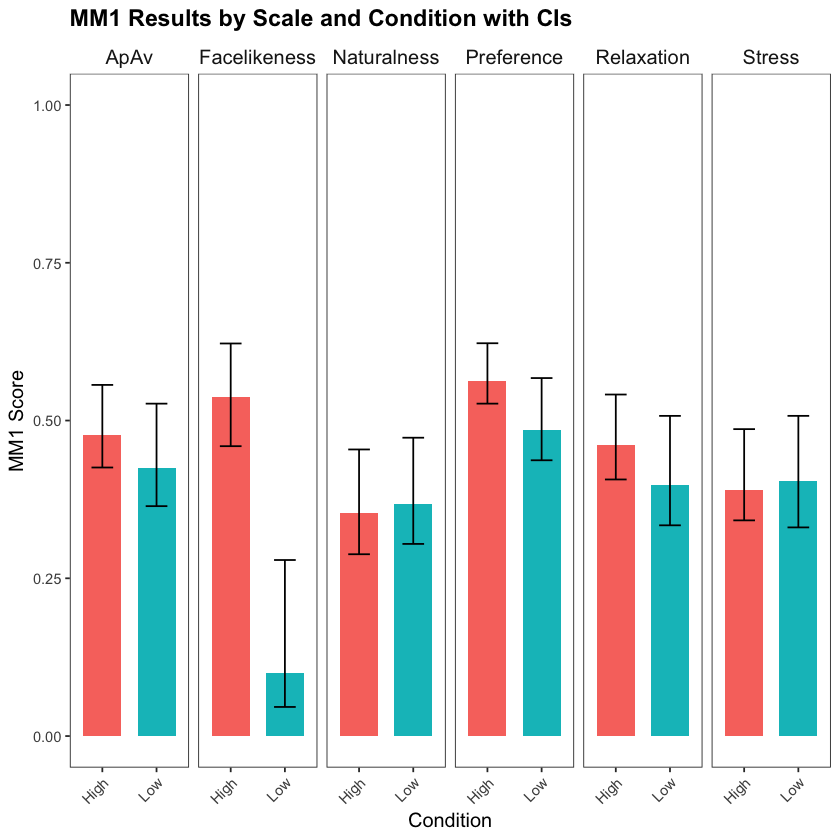

In [32]:
# save MM1_results as csv

MM1_results_high_df = data.frame(matrix(unlist(MM1_results_high), nrow = length(MM1_results_high), byrow = TRUE))
MM1_results_low_df = data.frame(matrix(unlist(MM1_results_low), nrow = length(MM1_results_low), byrow = TRUE))
# rows are scales, columns are MM1 and CI
colnames(MM1_results_high_df) <- c("MM1", "CI_lower", "CI_upper")
colnames(MM1_results_low_df) <- c("MM1", "CI_lower", "CI_upper")
rownames(MM1_results_high_df) <- scales
rownames(MM1_results_low_df) <- scales

#save
write.csv(MM1_results_high_df, paste0(tables, 'MM1_results_high.csv'), row.names = TRUE)
write.csv(MM1_results_low_df, paste0(tables, 'MM1_results_low.csv'), row.names = TRUE)

# add column Condition with "High"
MM1_results_high_df$Condition <- "High"
MM1_results_low_df$Condition <- "Low"

# add column Scale with scales
MM1_results_high_df$Scale <- rownames(MM1_results_high_df)
MM1_results_low_df$Scale <- rownames(MM1_results_low_df)

# combine the data frames
MM1_results_plot <- rbind(MM1_results_high_df, MM1_results_low_df)
print(MM1_results_plot)

# Ensure the CI columns are correctly named
MM1_results_plot$CI_lower <- MM1_results_plot$CI_lower
MM1_results_plot$CI_upper <- MM1_results_plot$CI_upper
library(ggplot2)

# Create the plot
p <- ggplot(MM1_results_plot, aes(x = Condition, y = MM1, fill = Condition)) +
  geom_bar(stat = "identity", position = position_dodge(), width = 0.7) +
  geom_errorbar(aes(ymin = CI_lower, ymax = CI_upper), width = 0.4) +
  facet_wrap(~ Scale,nrow = 1) +
  theme_apa() +
  labs(title = "MM1 Results by Scale and Condition with CIs",
       x = "Condition",
       y = "MM1 Score") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  # y label 0 to 1
  scale_y_continuous(limits = c(0, 1)) +
  #legend off
  theme(legend.position = "none") 
  # facet labels

# Show the plot
print(p)

*Consistency of Individual Ratings Across Scales*

The reliability of individual ratings was assessed using the intraclass correlation coefficient (ICC(3,1)), a two-way mixed-effects model for single measures, which evaluates the consistency of ratings across raters (participants) for the same set of stimuli (images). The ICC(3,1) values varied across scales, indicating low to moderate reliability for individual judgments. Facelikeness demonstrated the highest reliability (r=.43, 95% CI [.33, .55]), followed by Naturalness (r=.34, 95% CI [.25, .45]). In contrast, Relaxation (r=.19, 95% CI [.13, .28]) and ApAv (r=.22, 95% CI [.16, .32]) exhibited the lowest reliability, reflecting substantial variability in participants' responses.

| **Scale**       | **ICC(3,1)** | **95% CI**      | **Interpretation**       |
|------------------|--------------|-----------------|--------------------------|
| Preference       | .26          | [.19, .37]      | Poor reliability         |
| Naturalness      | .34          | [.25, .45]      | Fair reliability         |
| Facelikeness     | .43          | [.33, .55]      | Moderate reliability     |
| ApAv             | .22          | [.16, .32]      | Poor reliability         |
| Stress           | .24          | [.17, .34]      | Poor reliability         |
| Relaxation       | .19          | [.13, .28]      | Poor reliability         |


In [161]:
# ICC (3,1) fixed subject
# Initialize an empty list to store ICC results
icc_results <- list()
scales = c("Preference", "Naturalness", "Facelikeness", "ApAv", "Stress", "Relaxation")
# Loop through each scale
for (scale in scales) {
  cat("Processing scale:", scale, "\n")
  # Select the column for the current scale
  ratings <- rating_df %>%
    select(subject, House, all_of(scale)) %>%
    pivot_wider(names_from = House, values_from = all_of(scale)) %>%
    select(-subject) %>%  # Remove the subject column after reshaping
    mutate_all(as.numeric)  # Ensure all columns are numeric
  
  # Compute ICC using a two-way random-effects model
  icc_result <- ICC(ratings)
  
  # Store the result in the list
  icc_results[[scale]] <- icc_result

  # Print the ICC result i fyou want a printout (clutter)
  #print(icc_result)
}

Processing scale: Preference 
Processing scale: Naturalness 
Processing scale: Facelikeness 
Processing scale: ApAv 
Processing scale: Stress 
Processing scale: Relaxation 


In [162]:
# Print results
cat("Preference ICC Results:")
icc_results[["Preference"]]
cat("Naturalness ICC Results:")
icc_results[["Naturalness"]]
cat("Facelikeness ICC Results:")
icc_results[[ "Facelikeness"]]
cat("ApAv ICC Results:")
icc_results[[ "ApAv"]]
cat("Stress ICC Results:")
icc_results[[ "Stress"]]
cat("Relaxation ICC Results:")
icc_results[[ "Relaxation"]]

Preference ICC Results:

Call: ICC(x = ratings)

Intraclass correlation coefficients 
                         type  ICC  F df1  df2       p lower bound upper bound
Single_raters_absolute   ICC1 0.21 12  44 1755 2.7e-70        0.15        0.31
Single_random_raters     ICC2 0.22 15  44 1716 1.0e-93        0.15        0.31
Single_fixed_raters      ICC3 0.26 15  44 1716 1.0e-93        0.19        0.37
Average_raters_absolute ICC1k 0.91 12  44 1755 2.7e-70        0.87        0.95
Average_random_raters   ICC2k 0.92 15  44 1716 1.0e-93        0.88        0.95
Average_fixed_raters    ICC3k 0.93 15  44 1716 1.0e-93        0.90        0.96

 Number of subjects = 45     Number of Judges =  40
See the help file for a discussion of the other 4 McGraw and Wong estimates,

Naturalness ICC Results:

Call: ICC(x = ratings)

Intraclass correlation coefficients 
                         type  ICC  F df1  df2        p lower bound upper bound
Single_raters_absolute   ICC1 0.31 19  44 1755 4.3e-117        0.23        0.42
Single_random_raters     ICC2 0.31 21  44 1716 1.7e-130        0.23        0.42
Single_fixed_raters      ICC3 0.34 21  44 1716 1.7e-130        0.25        0.45
Average_raters_absolute ICC1k 0.95 19  44 1755 4.3e-117        0.92        0.97
Average_random_raters   ICC2k 0.95 21  44 1716 1.7e-130        0.92        0.97
Average_fixed_raters    ICC3k 0.95 21  44 1716 1.7e-130        0.93        0.97

 Number of subjects = 45     Number of Judges =  40
See the help file for a discussion of the other 4 McGraw and Wong estimates,

Facelikeness ICC Results:

Call: ICC(x = ratings)

Intraclass correlation coefficients 
                         type  ICC  F df1  df2        p lower bound upper bound
Single_raters_absolute   ICC1 0.32 19  44 1755 4.7e-120        0.23        0.43
Single_random_raters     ICC2 0.32 31  44 1716 1.6e-183        0.23        0.44
Single_fixed_raters      ICC3 0.43 31  44 1716 1.6e-183        0.33        0.55
Average_raters_absolute ICC1k 0.95 19  44 1755 4.7e-120        0.92        0.97
Average_random_raters   ICC2k 0.95 31  44 1716 1.6e-183        0.92        0.97
Average_fixed_raters    ICC3k 0.97 31  44 1716 1.6e-183        0.95        0.98

 Number of subjects = 45     Number of Judges =  40
See the help file for a discussion of the other 4 McGraw and Wong estimates,

ApAv ICC Results:

Call: ICC(x = ratings)

Intraclass correlation coefficients 
                         type  ICC  F df1  df2       p lower bound upper bound
Single_raters_absolute   ICC1 0.19 10  44 1755 1.3e-59        0.13        0.28
Single_random_raters     ICC2 0.19 12  44 1716 1.8e-74        0.13        0.28
Single_fixed_raters      ICC3 0.22 12  44 1716 1.8e-74        0.16        0.32
Average_raters_absolute ICC1k 0.90 10  44 1755 1.3e-59        0.86        0.94
Average_random_raters   ICC2k 0.90 12  44 1716 1.8e-74        0.86        0.94
Average_fixed_raters    ICC3k 0.92 12  44 1716 1.8e-74        0.88        0.95

 Number of subjects = 45     Number of Judges =  40
See the help file for a discussion of the other 4 McGraw and Wong estimates,

Stress ICC Results:

Call: ICC(x = ratings)

Intraclass correlation coefficients 
                         type  ICC  F df1  df2       p lower bound upper bound
Single_raters_absolute   ICC1 0.21 12  44 1755 7.6e-71        0.15        0.31
Single_random_raters     ICC2 0.22 14  44 1716 1.0e-83        0.15        0.31
Single_fixed_raters      ICC3 0.24 14  44 1716 1.0e-83        0.17        0.35
Average_raters_absolute ICC1k 0.92 12  44 1755 7.6e-71        0.88        0.95
Average_random_raters   ICC2k 0.92 14  44 1716 1.0e-83        0.88        0.95
Average_fixed_raters    ICC3k 0.93 14  44 1716 1.0e-83        0.89        0.95

 Number of subjects = 45     Number of Judges =  40
See the help file for a discussion of the other 4 McGraw and Wong estimates,

Relaxation ICC Results:

Call: ICC(x = ratings)

Intraclass correlation coefficients 
                         type  ICC    F df1  df2       p lower bound
Single_raters_absolute   ICC1 0.16  8.8  44 1755 3.8e-50        0.11
Single_random_raters     ICC2 0.17 10.5  44 1716 1.5e-61        0.11
Single_fixed_raters      ICC3 0.19 10.5  44 1716 1.5e-61        0.13
Average_raters_absolute ICC1k 0.89  8.8  44 1755 3.8e-50        0.83
Average_random_raters   ICC2k 0.89 10.5  44 1716 1.5e-61        0.84
Average_fixed_raters    ICC3k 0.90 10.5  44 1716 1.5e-61        0.86
                        upper bound
Single_raters_absolute         0.25
Single_random_raters           0.25
Single_fixed_raters            0.28
Average_raters_absolute        0.93
Average_random_raters          0.93
Average_fixed_raters           0.94

 Number of subjects = 45     Number of Judges =  40
See the help file for a discussion of the other 4 McGraw and Wong estimates,

In [40]:
# run again on high and low facelike houses: rating_df_high 

# Initialize an empty list to store ICC results
icc_results_high <- list()
icc_results_low <- list()

# Loop through each scale
for (scale in scales) {
  cat("Processing scale:", scale, "\n")
  # Select the column for the current scale
  ratings_high <- rating_df_high %>%
    select(subject, House, all_of(scale)) %>%
    pivot_wider(names_from = House, values_from = all_of(scale)) %>%
    select(-subject) %>%  # Remove the subject column after reshaping
    mutate_all(as.numeric)  # Ensure all columns are numeric
  
  ratings_low <- rating_df_low %>%
    select(subject, House, all_of(scale)) %>%
    pivot_wider(names_from = House, values_from = all_of(scale)) %>%
    select(-subject) %>%  # Remove the subject column after reshaping
    mutate_all(as.numeric)  # Ensure all columns are numeric
  
  # Compute ICC using a two-way random-effects model
  icc_result_high <- ICC(ratings_high)
  icc_result_low <- ICC(ratings_low)
  
  # Store the result in the list
  icc_results_high[[scale]] <- icc_result_high
  icc_results_low[[scale]] <- icc_result_low

  # Print the ICC result i fyou want a printout (clutter)
  #print(icc_result)
}

Processing scale: Preference 
Processing scale: Naturalness 
Processing scale: Facelikeness 
Processing scale: ApAv 
Processing scale: Stress 
Processing scale: Relaxation 


In [43]:
icc_results_high[["Facelikeness"]]
icc_results_low[["Facelikeness"]]

Call: ICC(x = ratings_high)

Intraclass correlation coefficients 
                         type  ICC  F df1 df2        p lower bound upper bound
Single_raters_absolute   ICC1 0.50 21  44 855 3.3e-107        0.40        0.62
Single_random_raters     ICC2 0.50 27  44 836 2.3e-129        0.40        0.63
Single_fixed_raters      ICC3 0.56 27  44 836 2.3e-129        0.46        0.68
Average_raters_absolute ICC1k 0.95 21  44 855 3.3e-107        0.93        0.97
Average_random_raters   ICC2k 0.95 27  44 836 2.3e-129        0.93        0.97
Average_fixed_raters    ICC3k 0.96 27  44 836 2.3e-129        0.94        0.98

 Number of subjects = 45     Number of Judges =  20
See the help file for a discussion of the other 4 McGraw and Wong estimates,

Call: ICC(x = ratings_low)

Intraclass correlation coefficients 
                         type  ICC  F df1 df2        p lower bound upper bound
Single_raters_absolute   ICC1 0.56 26  44 855 1.3e-129        0.46        0.68
Single_random_raters     ICC2 0.56 27  44 836 3.1e-130        0.46        0.68
Single_fixed_raters      ICC3 0.56 27  44 836 3.1e-130        0.46        0.68
Average_raters_absolute ICC1k 0.96 26  44 855 1.3e-129        0.94        0.98
Average_random_raters   ICC2k 0.96 27  44 836 3.1e-130        0.94        0.98
Average_fixed_raters    ICC3k 0.96 27  44 836 3.1e-130        0.95        0.98

 Number of subjects = 45     Number of Judges =  20
See the help file for a discussion of the other 4 McGraw and Wong estimates,

In [44]:
icc_results_high[["Preference"]]
icc_results_low[["Preference"]]

Call: ICC(x = ratings_high)

Intraclass correlation coefficients 
                         type  ICC    F df1 df2       p lower bound upper bound
Single_raters_absolute   ICC1 0.24  7.3  44 855 3.1e-36        0.17        0.35
Single_random_raters     ICC2 0.25 10.1  44 836 3.4e-52        0.17        0.36
Single_fixed_raters      ICC3 0.31 10.1  44 836 3.4e-52        0.23        0.43
Average_raters_absolute ICC1k 0.86  7.3  44 855 3.1e-36        0.80        0.92
Average_random_raters   ICC2k 0.87 10.1  44 836 3.4e-52        0.80        0.92
Average_fixed_raters    ICC3k 0.90 10.1  44 836 3.4e-52        0.85        0.94

 Number of subjects = 45     Number of Judges =  20
See the help file for a discussion of the other 4 McGraw and Wong estimates,

Call: ICC(x = ratings_low)

Intraclass correlation coefficients 
                         type  ICC   F df1 df2       p lower bound upper bound
Single_raters_absolute   ICC1 0.19 5.6  44 855 1.1e-25        0.12        0.29
Single_random_raters     ICC2 0.19 7.1  44 836 1.3e-34        0.13        0.29
Single_fixed_raters      ICC3 0.23 7.1  44 836 1.3e-34        0.16        0.34
Average_raters_absolute ICC1k 0.82 5.6  44 855 1.1e-25        0.74        0.89
Average_random_raters   ICC2k 0.83 7.1  44 836 1.3e-34        0.75        0.89
Average_fixed_raters    ICC3k 0.86 7.1  44 836 1.3e-34        0.79        0.91

 Number of subjects = 45     Number of Judges =  20
See the help file for a discussion of the other 4 McGraw and Wong estimates,

*Internal Consistency of Scales*

The half-split reliability was calculated for six scales: Preference, Naturalness, Facelikeness, ApAv, Stress, and Relaxation. The reliability values, corrected using the Spearman-Brown formula, were all within acceptable to excellent ranges. Facelikeness demonstrated the highest reliability, followed by Naturalness, Preference, Stress, Relaxation, and ApAv. These results suggest that the scales exhibit strong internal consistency.

| **Scale**       | **Reliability (r)** |
|------------------|---------------------|
| Preference       | .93                |
| Naturalness      | .95                |
| Facelikeness     | .98                |
| ApAv             | .90                |
| Stress           | .93                |
| Relaxation       | .92                |







In [163]:
half_split_reliability_with_pivot(rating_df, scales)

Reshaped data for scale: Preference 
Reliability for scale Preference : 0.9318845 
Reshaped data for scale: Naturalness 
Reliability for scale Naturalness : 0.9479331 
Reshaped data for scale: Facelikeness 
Reliability for scale Facelikeness : 0.982525 
Reshaped data for scale: ApAv 
Reliability for scale ApAv : 0.8962098 
Reshaped data for scale: Stress 
Reliability for scale Stress : 0.9339838 
Reshaped data for scale: Relaxation 
Reliability for scale Relaxation : 0.9171296 


$Preference
[1] 0.9318845

$Naturalness
[1] 0.9479331

$Facelikeness
[1] 0.982525

$ApAv
[1] 0.8962098

$Stress
[1] 0.9339838

$Relaxation
[1] 0.9171296

#### Basic Statistics 

*Descriptives*

Table: Descriptive statistics for each scale and condition

|Scale        |Condition     |     mean|       sd|   n|        se|
|:------------|:-------------|--------:|--------:|---:|---------:|
|ApAv         |High Facelike | 52.37000| 21.87674| 900| 0.7292245|
|ApAv         |Low Facelike  | 55.15111| 24.87306| 900| 0.8291019|
|Facelikeness |High Facelike | 37.08222| 31.46129| 900| 1.0487098|
|Facelikeness |Low Facelike  | 12.21111| 18.48698| 900| 0.6162327|
|Naturalness  |High Facelike | 48.23556| 22.72342| 900| 0.7574473|
|Naturalness  |Low Facelike  | 45.99889| 26.07589| 900| 0.8691964|
|Preference   |High Facelike | 46.39778| 23.37444| 900| 0.7791480|
|Preference   |Low Facelike  | 49.83556| 26.99894| 900| 0.8999647|
|Relaxation   |High Facelike | 50.59111| 23.52027| 900| 0.7840090|
|Relaxation   |Low Facelike  | 52.25000| 25.99907| 900| 0.8666358|
|Stress       |High Facelike | 38.83333| 23.18914| 900| 0.7729714|
|Stress       |Low Facelike  | 36.40667| 26.12853| 900| 0.8709508|

*Correlation between ratings*

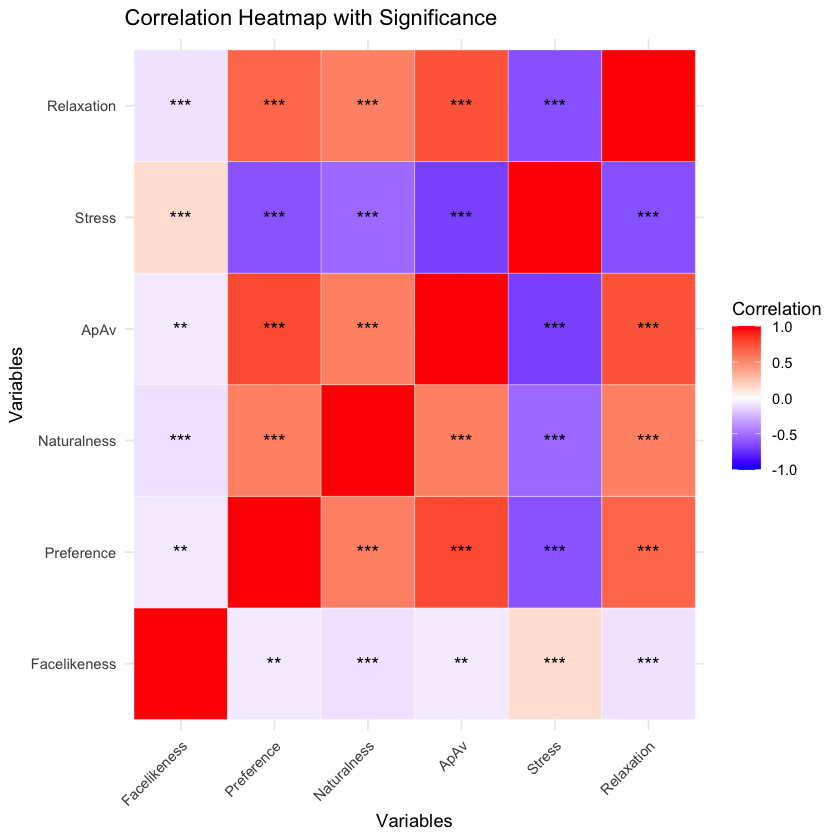

*Paired-samples t-test: Low vs High*

|                 |    Scale     | Mean_Difference |  t_Value  | Degrees_of_Freedom |  p_Value  |  CI_Lower   |  CI_Upper   |  Sig   |
|:----------------|:------------:|:---------------:|:---------:|:------------------:|:---------:|:-----------:|:-----------:|:-----------:|
|mean difference  |  Relaxation  |    1.658889     | 1.346533  |         44         | 0.1850264 | -0.8239840  |  4.1417618  |ns |
|mean difference1 |  Preference  |    3.437778     | 3.427613  |         44         | 0.0013319 |  1.4164336  |  5.4591219  | *** |
|mean difference2 | Naturalness  |    -2.236667    | -1.944300 |         44         | 0.0582699 | -4.5550880  |  0.0817547  |* |
|mean difference3 | Facelikeness |   -24.871111    | -8.851104 |         44         | 0.0000000 | -30.5341825 | -19.2080397 |***|
|mean difference4 |     ApAv     |    2.781111     | 2.781532  |         44         | 0.0079364 |  0.7660482  |  4.7961740  |**|
|mean difference5 |    Stress    |    -2.426667    | -1.815805 |         44         | 0.0762183 | -5.1200315  |  0.2666981  |*|




In [41]:
colnames(rating_df)

[1] "X"            "Image"        "Preference"   "Naturalness"  "Facelikeness"
 [6] "ApAv"         "Stress"       "Relaxation"   "subject"      "House"       
[11] "Condition"

In [5]:
# Reshape to very long format
data_very_long <- rating_df %>%
  pivot_longer(
    cols = Preference:Relaxation, # Columns to pivot
    names_to = "Scale",         # New column for scale names
    values_to = "Rating"        # New column for ratings
  )

# IMPORTANT DIAGNOSTICS: 
# Check for missing values. If there are missing values go back and check if that's glitch or participant didn't move slider (mostly on purpose)
missing_rows <- data_very_long[is.na(data_very_long$Rating), ]
if(nrow(missing_rows) > 0) {
  print('Missing values found')
} else {
  print('No missing values')
}

[1] "No missing values"


In [151]:
# ok create pivot that counts how many occurances of each Image in each scale is there

data_diagnostic <- rating_df %>%
  pivot_longer(
    cols = Preference:Relaxation, # Columns to pivot
    names_to = "Scale",         # New column for scale names
    values_to = "Rating"        # New column for ratings
  ) %>%
  group_by(Image) %>%
  summarise(n = n()) %>%
  ungroup()



Table: Descriptive statistics for each scale and condition

|Scale        |Condition     |     mean|       sd|   n|        se|
|:------------|:-------------|--------:|--------:|---:|---------:|
|ApAv         |High Facelike | 52.37000| 21.87674| 900| 0.7292245|
|ApAv         |Low Facelike  | 55.15111| 24.87306| 900| 0.8291019|
|Facelikeness |High Facelike | 37.08222| 31.46129| 900| 1.0487098|
|Facelikeness |Low Facelike  | 12.21111| 18.48698| 900| 0.6162327|
|Naturalness  |High Facelike | 48.23556| 22.72342| 900| 0.7574473|
|Naturalness  |Low Facelike  | 45.99889| 26.07589| 900| 0.8691964|
|Preference   |High Facelike | 46.39778| 23.37444| 900| 0.7791480|
|Preference   |Low Facelike  | 49.83556| 26.99894| 900| 0.8999647|
|Relaxation   |High Facelike | 50.59111| 23.52027| 900| 0.7840090|
|Relaxation   |Low Facelike  | 52.25000| 25.99907| 900| 0.8666358|
|Stress       |High Facelike | 38.83333| 23.18914| 900| 0.7729714|
|Stress       |Low Facelike  | 36.40667| 26.12853| 900| 0.8709508|

Warning message in geom_boxplot(width = 0.1, guides = FALSE, outlier.shape = NA, :
“Ignoring unknown parameters: `guides`”
Warning message:
“Using the `size` aesthetic with geom_polygon was deprecated in ggplot2 3.4.0.
ℹ Please use the `linewidth` aesthetic instead.”


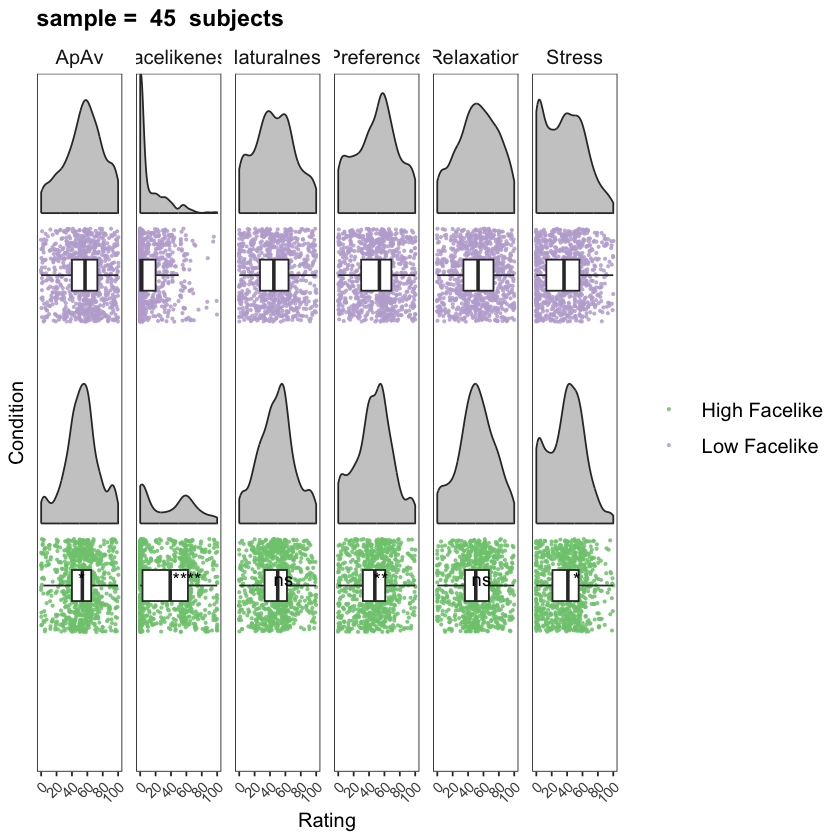

In [46]:
# Compute descriptive statistics by Scale and Condition
descriptive_stats <- data_very_long %>%
  group_by(Scale, Condition) %>%
  summarise(
    mean = mean(Rating, na.rm = TRUE),
    sd = sd(Rating, na.rm = TRUE),
    n = sum(!is.na(Rating)),
    se = sd(Rating, na.rm = TRUE) / sqrt(sum(!is.na(Rating))),
    .groups = 'drop'
  )

# Format the results with kable
# Knit the table
knitr::kable(descriptive_stats, caption = "Descriptive statistics for each scale and condition", format = "markdown") 

p <- ggplot(data_very_long, aes(x = Condition, y = Rating, fill = Condition)) +
  geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8, fill = "gray") +
  geom_point(aes(color = Condition), position = position_jitter(width = .15), size = .5, alpha = 0.8) +
  geom_boxplot(width = .1, guides = FALSE, outlier.shape = NA, fill = "white") +
  #geom_jitter(aes(color = Condition), width = .2, alpha = .8) +
  # t-test annotation
  stat_compare_means(method = "t.test", label = "p.signif", label.y = 50) +
  scale_colour_brewer(palette = "Accent") +
  scale_fill_brewer(palette = "Accent") +
  coord_flip() +
  theme_apa() +
  scale_y_continuous(breaks = seq(0, 100, by = 20),) + 
  labs(title = paste("sample = ", n_subjects, " subjects")) +
  facet_wrap(~ Scale, scales = "free_y", nrow = 1) + theme(axis.text.y = element_text(size = 6)) +
# remove the Y axis labels
  theme(axis.text.y = element_blank(),
      axis.ticks.y = element_blank()) +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))
  

    # ad
p
# Save as wide format
# Save the plot with specified dimensions
ggsave(paste0(figures, "ratings_violin_plot.png"), plot = p, width = 10, height = 5, units = "in", dpi = 300)

Warning message in geom_boxplot(width = 0.1, guides = FALSE, outlier.shape = NA, :
“Ignoring unknown parameters: `guides`”
Warning message:
“Duplicated `override.aes` is ignored.”
Warning message:
“Duplicated `override.aes` is ignored.”


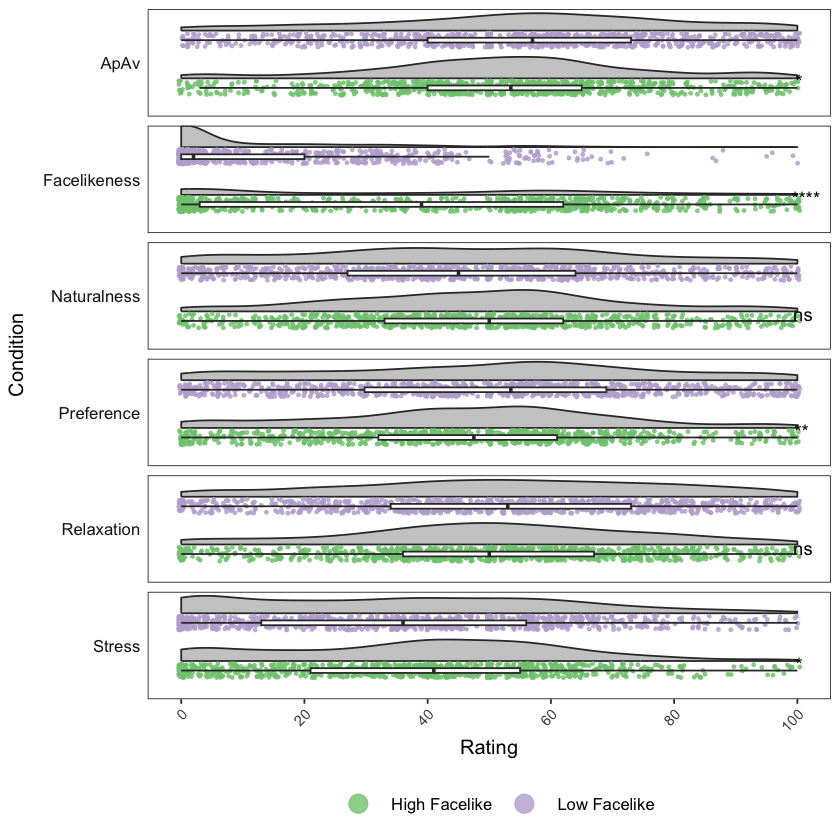

In [152]:
p <- ggplot(data_very_long, aes(x = Condition, y = Rating, fill = Condition)) +
  geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8, fill = "gray") +
  geom_point(aes(color = Condition), position = position_jitter(width = .15), size = .7, alpha = 0.8) +
  geom_boxplot(width = .1, guides = FALSE, outlier.shape = NA, fill = "white") +
  # t-test annotation
  stat_compare_means(method = "t.test", label = "p.signif", label.y = 100) +
  scale_colour_brewer(palette = "Accent") +
  scale_fill_brewer(palette = "Accent") +
  coord_flip() +
  theme_apa() +
  scale_y_continuous(breaks = seq(0, 100, by = 20)) + 
  #labs(title = paste("sample = ", n_subjects, " subjects")) +
  facet_wrap(~ Scale, scales = "free_y", ncol = 1, strip.position = "left") + # Move facet labels to the left
  theme(
    strip.text.y.left = element_text(angle = 0, hjust = 1, size = 10), # Align text to the left
    strip.background = element_blank(), # Optional: Remove background from strip labels
    axis.text.y = element_blank(),
    axis.ticks.y = element_blank(),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    legend.position = "bottom", # Place legend at the bottom
    legend.text = element_text(size = 10),
    legend.key.size = unit(1.5, "lines")) +
  guides(fill = guide_legend(override.aes = list(size = 5)),
         color = guide_legend(override.aes = list(size = 5)))

# Save as wide format
ggsave(paste0(figures, "ratings_violin_plot_horizontal_with_left_labels.png"), plot = p, width = 7, height = 10, units = "in", dpi = 300)

p



Warning message in geom_boxplot(aes(fill = Condition), width = 0.1, guides = FALSE, :
“Ignoring unknown parameters: `guides`”
Warning message:
“Duplicated `override.aes` is ignored.”
Warning message:
“Duplicated `override.aes` is ignored.”


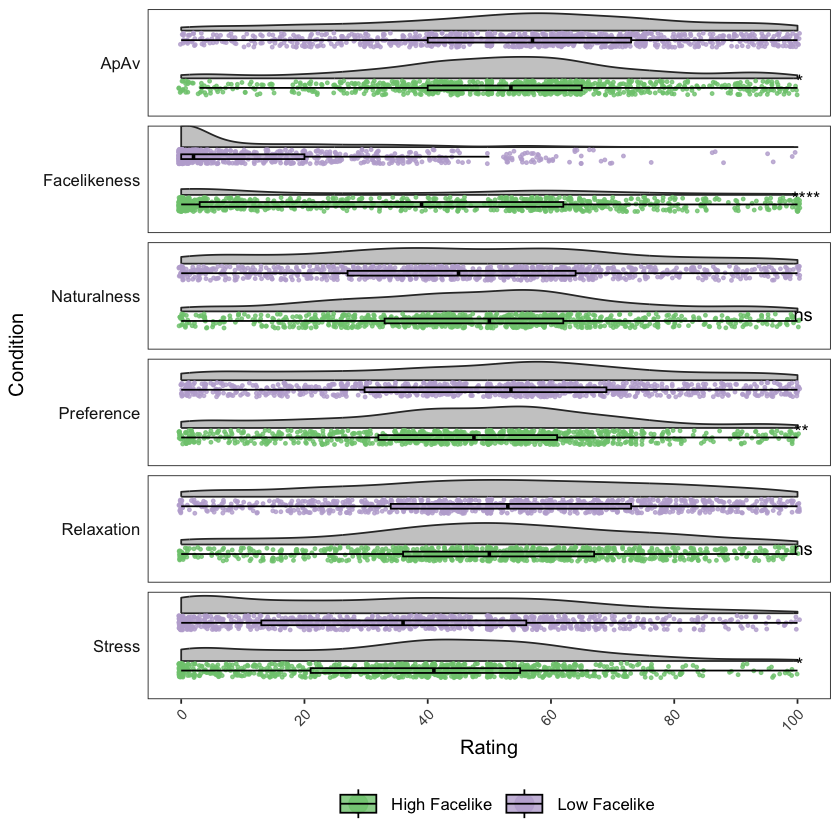

In [153]:
p <- ggplot(data_very_long, aes(x = Condition, y = Rating)) +
  geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8, fill = "gray") + # Keep violin plots gray
  geom_point(aes(color = Condition), position = position_jitter(width = .15), size = .7, alpha = 0.8) +
  geom_boxplot(aes(fill = Condition), width = .1, guides = FALSE, outlier.shape = NA, color = "black", alpha = 0.8) + # Boxplot fill color by Condition
  # t-test annotation
  stat_compare_means(method = "t.test", label = "p.signif", label.y = 100) +
  scale_colour_brewer(palette = "Accent") + # Point color palette
  scale_fill_brewer(palette = "Accent") + # Fill color palette for boxplots
  coord_flip() +
  theme_apa() +
  scale_y_continuous(breaks = seq(0, 100, by = 20)) + 
  #labs(title = paste("sample = ", n_subjects, " subjects")) +
  facet_wrap(~ Scale, scales = "free_y", ncol = 1, strip.position = "left") + # Facet labels on the left
  theme(
    strip.text.y.left = element_text(angle = 0, hjust = 1, size = 10),
    strip.background = element_blank(),
    axis.text.y = element_blank(),
    axis.ticks.y = element_blank(),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    legend.position = "bottom", # Place legend at the bottom
    legend.text = element_text(size = 10),
    legend.key.size = unit(1.5, "lines")) +
  guides(fill = guide_legend(override.aes = list(size = 5)),
         color = guide_legend(override.aes = list(size = 5)))

# Save as wide format
ggsave(paste0(figures, "ratings_violin_plot_grey_violin_colored_boxplot.png"), plot = p, width = 5, height = 10, units = "in", dpi = 300)

p



In [6]:
# Paired t-tests
# I need an average ratings for each condition rating and each subject
rating_df$Condition = as.factor(rating_df$Condition)
rating_df$subject = as.factor(rating_df$subject)

# pivot the data into wide format
rating_df_pivot = rating_df %>%
  pivot_wider(names_from = Condition, values_from = c(Preference, Naturalness, Facelikeness, ApAv, Stress, Relaxation)) %>%
  group_by(subject) %>%
  summarise(across(everything(), mean, na.rm = TRUE))

# remove the column Image nad House
rating_df_pivot = rating_df_pivot[, -c(2,3,4)]
# replace spaces in the column names with _
colnames(rating_df_pivot) = gsub(" ", "_", colnames(rating_df_pivot))
# knitr didn't work unless I put the code in the chunk
library(knitr)

# Example for multiple variables
results <- list(
    Relaxation = t.test(rating_df_pivot$Relaxation_Low_Facelike, rating_df_pivot$Relaxation_High_Facelike, paired = TRUE),
    Preference = t.test(rating_df_pivot$Preference_Low_Facelike, rating_df_pivot$Preference_High_Facelike, paired = TRUE),
    Naturalness = t.test(rating_df_pivot$Naturalness_Low_Facelike, rating_df_pivot$Naturalness_High_Facelike, paired = TRUE),
    Facelikeness = t.test(rating_df_pivot$Facelikeness_Low_Facelike, rating_df_pivot$Facelikeness_High_Facelike, paired = TRUE),
    ApAv = t.test(rating_df_pivot$ApAv_Low_Facelike, rating_df_pivot$ApAv_High_Facelike, paired = TRUE),
    Stress = t.test(rating_df_pivot$Stress_Low_Facelike, rating_df_pivot$Stress_High_Facelike, paired = TRUE)
)


# Extract results into a data frame
t_test_table <- do.call(rbind, lapply(names(results), function(variable) {
  test <- results[[variable]]
  data.frame(
    Scale = variable,
    Mean_Difference = test$estimate,
    t_Value = test$statistic,
    Degrees_of_Freedom = test$parameter,
    p_Value = test$p.value,
    CI_Lower = test$conf.int[1],
    CI_Upper = test$conf.int[2]
  )
}))

# View the formatted table
knitr::kable(t_test_table, format = "markdown", align = "c")

# Save the table as a CSV
write.csv(t_test_table, paste0(tables, "t_test_table.csv"), row.names = FALSE)


Warning message:
“There were 91 warnings in `summarise()`.
The first warning was:
ℹ In argument: `across(everything(), mean, na.rm = TRUE)`.
ℹ In group 1: `subject = sub-0643EC`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))
ℹ Run `dplyr::last_dplyr_warnings()` to see the 90 remaining warnings.”




|                 |    Scale     | Mean_Difference |  t_Value  | Degrees_of_Freedom |  p_Value  |  CI_Lower   |  CI_Upper   |
|:----------------|:------------:|:---------------:|:---------:|:------------------:|:---------:|:-----------:|:-----------:|
|mean difference  |  Relaxation  |    1.658889     | 1.346533  |         44         | 0.1850264 | -0.8239840  |  4.1417618  |
|mean difference1 |  Preference  |    3.437778     | 3.427613  |         44         | 0.0013319 |  1.4164336  |  5.4591219  |
|mean difference2 | Naturalness  |    -2.236667    | -1.944300 |         44         | 0.0582699 | -4.5550880  |  0.0817547  |
|mean difference3 | Facelikeness |   -24.871111    | -8.851104 |         44         | 0.0000000 | -30.5341825 | -19.2080397 |
|mean difference4 |     ApAv     |    2.781111     | 2.781532  |         44         | 0.0079364 |  0.7660482  |  4.7961740  |
|mean difference5 |    Stress    |    -2.426667    | -1.815805 |         44         | 0.0762183 | -5.1200315  |  0.2

Warning message:
“Removed 6 rows containing missing values (`geom_text()`).”


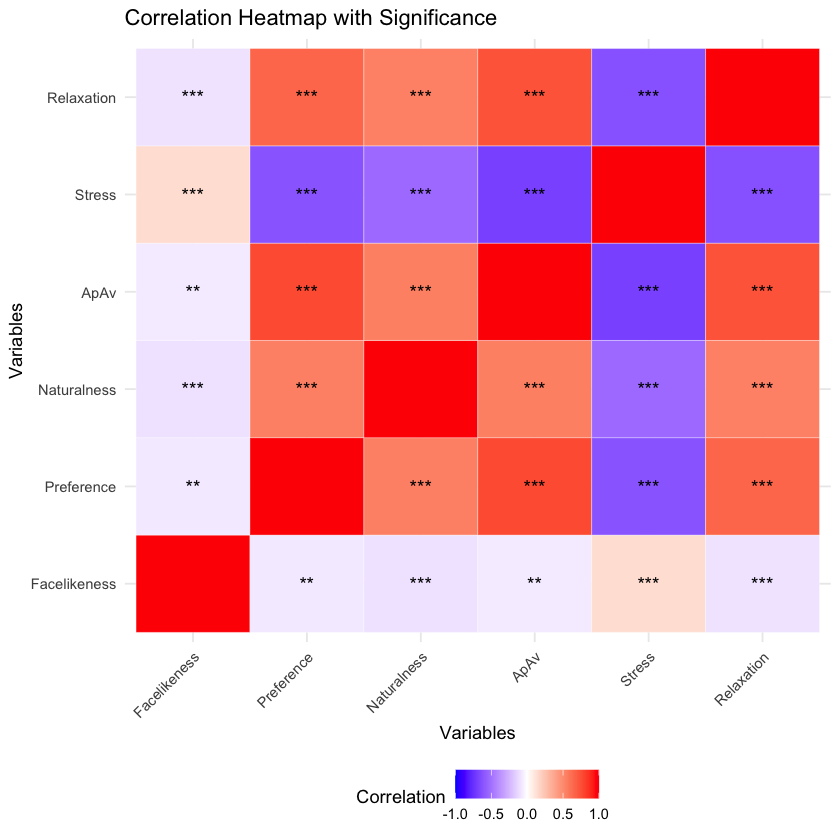

In [ ]:
library(ggplot2)
library(reshape2)
library(Hmisc)

# Calculate correlation matrix and p-values
cor_results <- rcorr(as.matrix(rating_df[, c('Facelikeness', 'Preference', 'Naturalness', 'ApAv', 'Stress', 'Relaxation')]), 
                     type = "pearson")
correlation <- cor_results$r  # Correlation coefficients
p_values <- cor_results$P     # P-values

# Melt correlation matrix and p-values to long format
correlation_long <- melt(correlation)
p_values_long <- melt(p_values)

# Combine correlations and p-values
correlation_long$p_value <- p_values_long$value

# Add significance levels based on p-values
correlation_long$significance <- cut(correlation_long$p_value, 
                                     breaks = c(-Inf, 0.001, 0.01, 0.05, Inf), 
                                     labels = c("***", "**", "*", ""))

# Create the heatmap
ggplot(correlation_long, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile(color = "white") +
  geom_text(aes(label = significance), color = "black", size = 4) +  # Add significance stars
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                       midpoint = 0, limit = c(-1, 1), space = "Lab", 
                       name = "Correlation") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
  # add legend with p-values and significance levels 
  labs(x = "Variables", y = "Variables", title = "Correlation Heatmap with Significance")


#### Ratings: LME

On `data_very_long` 

In [7]:
# LME with interactive effect between condition low/high facelikeness and ratings with subject and image as random effects.
# relevel the condition
# Ensure the Condition column is a factor
data_very_long$Condition <- as.factor(data_very_long$Condition)

# Relevel the Condition factor to set "Low Facelike" as the reference level
data_very_long$Condition <- relevel(data_very_long$Condition, ref = "Low Facelike")


model <- lmer(Rating ~ Condition * Scale + (1 | subject) + (1 | Image), data = data_very_long)
# tab model and save as rtf
tab_model(model,show.reflvl = TRUE) #, file = paste0(tables, "lme_model.html"))

In [55]:
# on short data
# facelikeness predicted by condition with subject and image as random effects

model_facelikeness <- lmer(Facelikeness ~ Condition + (1 | subject) + (1 | Image), data = rating_df)

# tab model and save as rtf
tab_model(model_facelikeness,show.reflvl = TRUE) #, file = paste0(tables, "lme_model_facelikeness.html"))

In [169]:
# Post-hoc comparisons for the interaction between Condition and Scale
emmeans_results <- emmeans(model, pairwise ~ Condition * Scale)
emm_table <- as.data.frame(emmeans_results$emmeans)
emm_table_apa <- emm_table[, c("Condition", "Scale", "emmean", "asymp.LCL", "asymp.UCL")]
colnames(emm_table_apa) <- c("Condition", "Scale", "Mean", "Lower CI", "Upper CI")
# save as csv
write.csv(emm_table_apa, paste0(tables, "emmeans_table_APA.csv"), row.names = FALSE)

# contrasts the same
contrasts_table <- as.data.frame(emmeans_results$contrasts)
contrasts_table_apa <- contrasts_table[, c("contrast", "estimate", "SE", "df", "z.ratio", "p.value")]

# Save as CSV
write.csv(contrasts_table_apa, paste0(tables, "contrasts_table_APA.csv"), row.names = FALSE)

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 10800' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 10800)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 10800' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 10800)' or larger];
but be warned that this may result in large computation time and memory use.



### SSAT

*Multidimensional Scalling of the inter-item proximites*

Similarity judgements were processed on the go by psychopy into euclidean distances. They are been loaded for each participant.

Non-metric Multidimensional Scaling (MDS) was conducted to analyze the similarity judgments for the set of items (houses). The aim was to explore the underlying dimensionality of the judgments and identify potential patterns in the perceived relationships among the items.The final stress value for the MDS solution was 9.66, indicating an acceptable fit of the 2-dimensional solution to the observed similarity matrix. Lower stress values (< 10%) suggest that the two-dimensional representation adequately captures the distances among items. However, stress value of 9.66 suggests that the two-dimensional solution is reasonable but may not fully capture all variance in the similarity data. This is within acceptable bounds for exploratory MDS analyses.


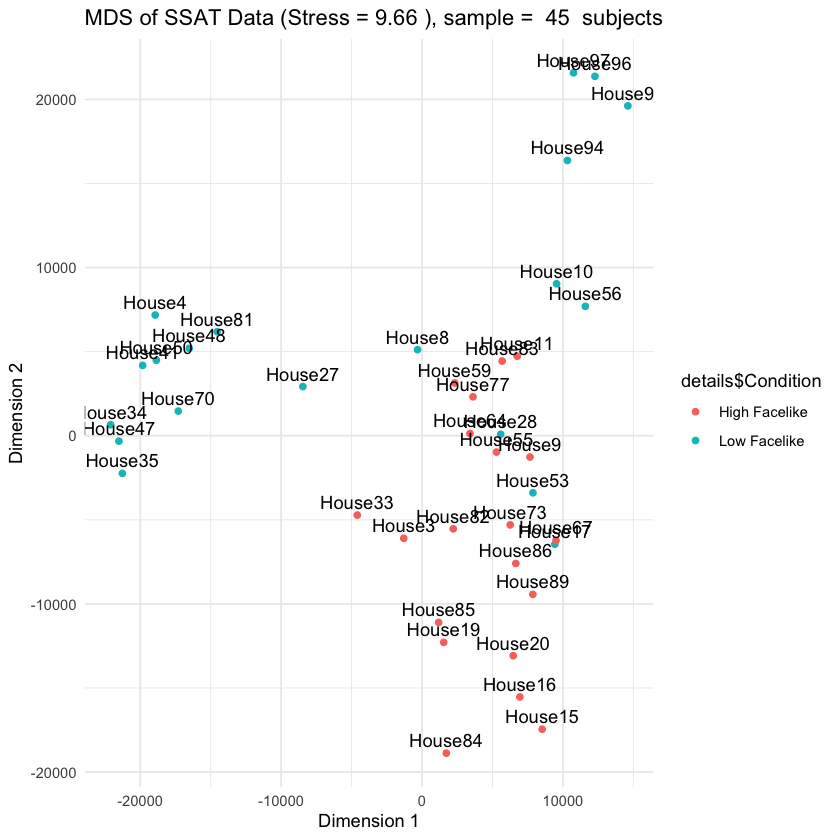   


What predicts dimension 1 and 2? 

*Multiple Regression*

Table: Linear Model Summary for Dimension 1

|             |   Estimate|  Std. Error|    t value| Pr(>&#124;t&#124;)|
|:------------|----------:|-----------:|----------:|------------------:|
|(Intercept)  | -996.60553| 1441.198552| -0.6915116|          0.4893363|
|Preference   |  -37.53852|   16.916040| -2.2191079|          0.0266079|
|Naturalness  |   14.44288|   13.527718|  1.0676508|          0.2858261|
|Facelikeness |   78.84580|    9.169276|  8.5989118|          0.0000000|
|ApAv         |   11.03931|   20.931065|  0.5274125|          0.5979743|
|Stress       |   14.38718|   15.453593|  0.9309928|          0.3519864|
|Relaxation   |  -19.79553|   16.388495| -1.2078919|          0.2272529|


Table: Linear Model Summary for Dimension 2

|             |    Estimate|  Std. Error|     t value| Pr(>&#124;t&#124;)|
|:------------|-----------:|-----------:|-----------:|------------------:|
|(Intercept)  | 1896.277673| 1212.982335|   1.5633185|          0.1181594|
|Preference   |   60.343162|   14.237357|   4.2383684|          0.0000237|
|Naturalness  |  -74.773121|   11.385581|  -6.5673523|          0.0000000|
|Facelikeness |  -80.510073|    7.717306| -10.4324066|          0.0000000|
|ApAv         |   30.243392|   17.616596|   1.7167557|          0.0862017|
|Stress       |   -3.775086|   13.006491|  -0.2902463|          0.7716623|
|Relaxation   |  -13.823795|   13.793349|  -1.0022073|          0.3163828|


The LME analysis shows that Facelikeness is a strong positive predictor of Dimension 1, suggesting that items rated as more facelike are strongly associated with higher scores on this dimension. Preference is a weaker but significant negative predictor, indicating a slight inverse relationship. The lack of significance for other predictors suggests that they do not substantially influence Dimension 1 in this model. The marginal R2 suggests that the fixed effects explain a small portion of the total variance. The random effects indicated no significant subject-level variance (τ00=0.00), suggesting that the random intercept did not substantially contribute to the model.

The results of LME for Dimension2, indicate that Preference, Naturalness, and Facelikeness are significant predictors of Dimension 2. Higher Preference ratings are associated with increased Dimension 2 scores, whereas higher Naturalness and Facelikeness ratings are associated with decreased scores on this dimension. The ICC of 0.00 and negligible variance in random effects suggest that individual differences between subjects did not substantially contribute to variability in Dimension 2. These findings highlight Dimension 2 as a construct driven primarily by fixed predictors, with Preference opposing Naturalness and Facelikeness. Feelings of Stress and Relaxation did not significantly influence Dimension 2.



In [5]:
# Prepare data: 
# add a column with the column names
column_names = colnames(ssat_sum)

# add the column names as a column to the data frame
ssat_sum = cbind(data.frame(House = column_names), ssat_sum)

# copy only the numeric columns to 40 x 40 matrix
ssat_sum_numeric = ssat_sum[,2:ncol(ssat_sum)]
# to column_names add the condition 
# IMPORTANT:
# high facelike Houses: 3,9,11,15,16,19,20,33,55,59,64,67,73,77,82,83,84,85,86,89
# low facelike Houses: 4,8,10,17,27,28,34,35,41,47,48,50,53,56,70,81,94,96,97,98

# create a new column for Condition. If the House is in the list of high facelike houses, then assign high facelike, otherwise low facelike
details = as.data.frame(column_names)
# separate House from a number and keep the number
details$House = gsub("House", "", details$column_names)
# if the number is in the list of high facelike houses, then assign high facelike, otherwise low facelike
details$Condition = ifelse(as.numeric(details$House) %in% c(3,9,11,15,16,19,20,33,55,59,64,67,73,77,82,83,84,85,86,89), 'High Facelike', 'Low Facelike')



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘ggimage’


The following object is masked from ‘package:ggpubr’:

    theme_transparent


The following object is masked from ‘package:cowplot’:

    theme_nothing




initial  value 9.656317 
final  value 9.656316 
converged
[1] "Stress value: 9.65631639176272"


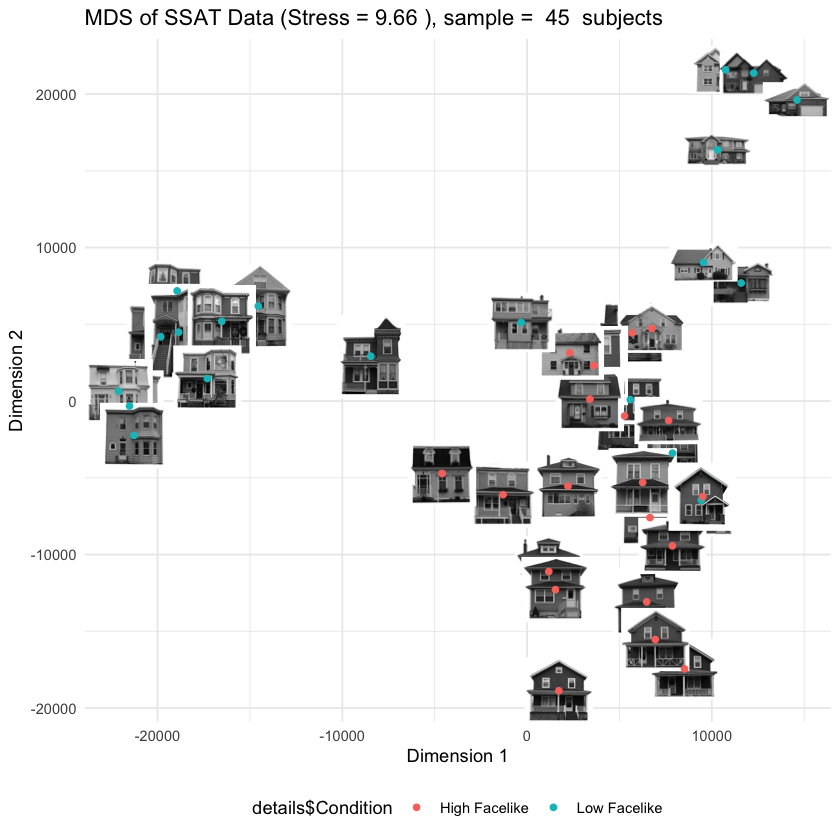

In [6]:
# Perform non metric MDS
library(MASS)
library(ggimage)
path_to_images = '/Users/sztuka/Documents/ARCH2/images/'
# as matrix
ssat_sum_numeric = as.matrix(ssat_sum_numeric)

# Perform Multidimensional Scaling (MDS) with isoMDS to get stress
mds_result <- isoMDS(ssat_sum_numeric, k = 6)

# Extract the MDS coordinates and stress
mds_coords <- mds_result$points
stress <- mds_result$stress

# Convert the coordinates to a data frame for easier handling
mds_df <- as.data.frame(mds_coords)
colnames(mds_df) <- c("Dim1", "Dim2","Dim3","Dim4","Dim5","Dim6")
mds_df$image_paths = paste0(path_to_images, 'House',details$House, '.jpg')
#print(mds_df$image_paths)

# Print the MDS results and stress value
# print(mds_df)
print(paste("Stress value:", stress))

# Plot the MDS results with labels
ggplot(mds_df, aes(x = Dim1, y = Dim2)) +
  #geom_point() +
  # Add images as labels
  geom_image(aes(image = image_paths), size = 0.1) + #,position = position_jitter(width = 2000, height = 2000)) + # Adjust size as needed
  # Add color to the points based on the condition in details$Condition
  geom_point(aes(color = details$Condition)) +
  #geom_text(aes(label = column_names), vjust = -0.5, hjust = 0.5) +
  theme_minimal() +
  # legend at the bottom
  theme(legend.position = "bottom") +
  labs(title = paste("MDS of SSAT Data (Stress =", round(stress, 2), "), sample = ", n_subjects, " subjects"),
       x = "Dimension 1",
       y = "Dimension 2")

ggsave(paste0(figures, "mds_plot.png"), width = 10, height = 10, units = "in", dpi = 300)

In [23]:
# Install and load the plotly package
#install.packages("plotly")
library(plotly)

# Assuming your MDS data has three dimensions: Dim1, Dim2, Dim3
# mds_df contains Dim1, Dim2, Dim3, and details$Condition for coloring
#
plot_ly(
  data = mds_df,
  x = ~Dim1,
  y = ~Dim2,
  z = ~Dim3,
  type = "scatter3d",
  mode = "markers+text",
  color = ~details$Condition, # Color points based on Condition
  text = ~column_names,       # Add text labels for points
  marker = list(size = 5)     # Adjust marker size
) %>%
  layout(
    title = list(
      text = paste("MDS of SSAT Data (Stress =", round(stress, 2), "), sample = ", n_subjects, " subjects"),
      x = 0.5
    ),
    scene = list(
      xaxis = list(title = "Dimension 1"),
      yaxis = list(title = "Dimension 2"),
      zaxis = list(title = "Dimension 3")
    )
  )

# Save to an HTML file
htmlwidgets::saveWidget(plot, paste0(figures, "mds_plotly.html"))

Warning message in RColorBrewer::brewer.pal(N, "Set2"):
“minimal value for n is 3, returning requested palette with 3 different levels
”
Warning message in RColorBrewer::brewer.pal(N, "Set2"):
“minimal value for n is 3, returning requested palette with 3 different levels
”
Warning message in RColorBrewer::brewer.pal(N, "Set2"):
“minimal value for n is 3, returning requested palette with 3 different levels
”
Warning message in RColorBrewer::brewer.pal(N, "Set2"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


HTML widgets cannot be represented in plain text (need html)

ERROR: Error in x$elementId: object of type 'closure' is not subsettable


In [7]:
# mds_df add this to rating_df
rating_df$Dim1 <- mds_df$Dim1
rating_df$Dim2 <- mds_df$Dim2
rating_df$Dim3 <- mds_df$Dim3

# load Anthropometric data
anthropometric_data = read.csv('Anth_covariate.csv',header = TRUE, sep = ",")
#add 'sub-'' to subject id
anthropometric_data$subject = paste0('sub-',anthropometric_data$subject)
# Calculate the mean of columns 2 to 10 for each row
anthropometric_data$mean_values <- rowMeans(anthropometric_data[, 2:10], na.rm = TRUE)
# average anthropometric data for each subject
# ant1 dimension: ANT_1 = (ANT1 + ANT3 +ANT5) / 3; ANT_2 = (ANT2 + ANT6 +ANT9) / 3; ANT_3 = (ANT4 + ANT7 +ANT8) / 3
anthropometric_data$ANT_dim1 = (anthropometric_data$ANT1 + anthropometric_data$ANT3 +anthropometric_data$ANT5) / 3
anthropometric_data$ANT_dim2 = (anthropometric_data$ANT2 + anthropometric_data$ANT6 +anthropometric_data$ANT9) / 3
anthropometric_data$ANT_dim3 = (anthropometric_data$ANT4 + anthropometric_data$ANT7 +anthropometric_data$ANT8) / 3
#anthropometric_data$mean = aggregate(anthropometric_data, by = list(anthropometric_data$subject), FUN = mean)

# merge the ratings with the mean anthropometric data
rating_df = merge(rating_df, anthropometric_data, by = 'subject')

In [21]:
# repeat the LME model with the new data

# on short data
# facelikeness predicted by condition with subject and image as random effects

# relevel to high facelike

rating_df$Condition = relevel(rating_df$Condition, ref = "Low Facelike")

model_facelikeness <- lmer(Facelikeness ~ Condition + (1 | subject) + (1 | Image), data = rating_df)

model_anthropo <- lmer(Facelikeness ~ Condition * mean_values + (1 | subject) + (1 | Image), data = rating_df)

model_anthcompo <- lmer(Facelikeness ~ Condition * ANT_dim1 + Condition *ANT_dim2 + Condition *ANT_dim3 + (1 | subject) + (1 | Image), data = rating_df)

# tab model and save as rtf
tab_model(model_facelikeness,model_anthropo,model_anthcompo, show.reflvl = TRUE) #, file = paste0(tables, "lme_model_facelikeness.html"))


`geom_smooth()` using formula = 'y ~ x'


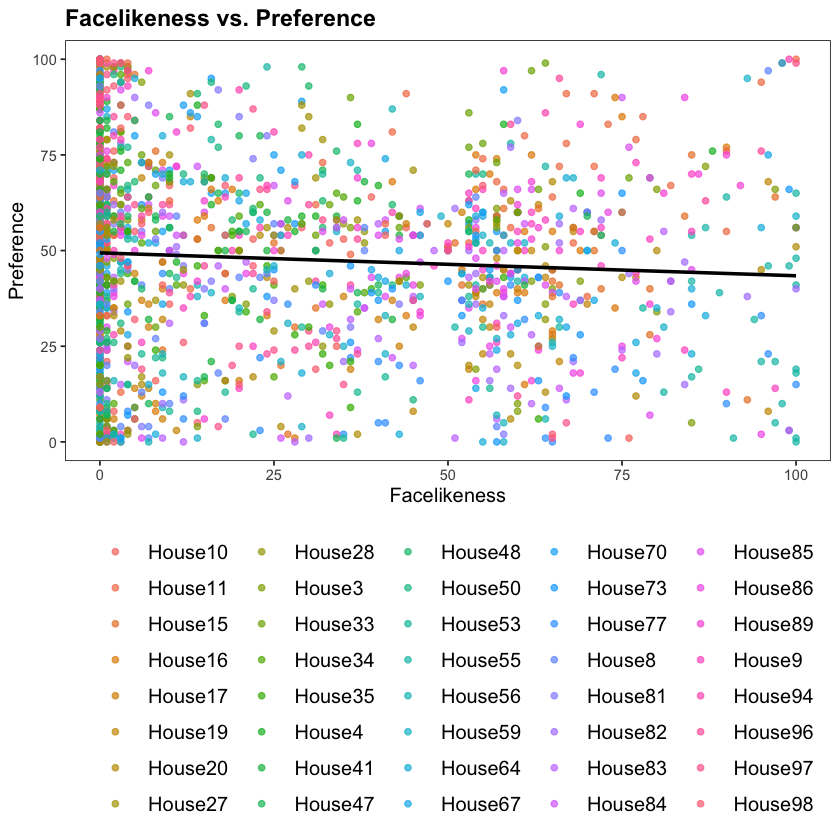

In [ ]:
# can we plot Facelikeness against Preference and see if any image is driving the effect?

# Create the scatter plot
p <- ggplot(rating_df, aes(x = Facelikeness, y = Preference, color = Image)) +
  geom_point(alpha = 0.7) +  # Add points with some transparency
  geom_smooth(method = "lm", se = FALSE, color = "black") +  # Add a linear regression line
  theme_apa() +
  # color of points
  
  labs(title = "Facelikeness vs. Preference",
       x = "Facelikeness",
       y = "Preference") +
  theme(legend.position = "bottom")  # Position the legend on the right

# Show the plot
print(p)

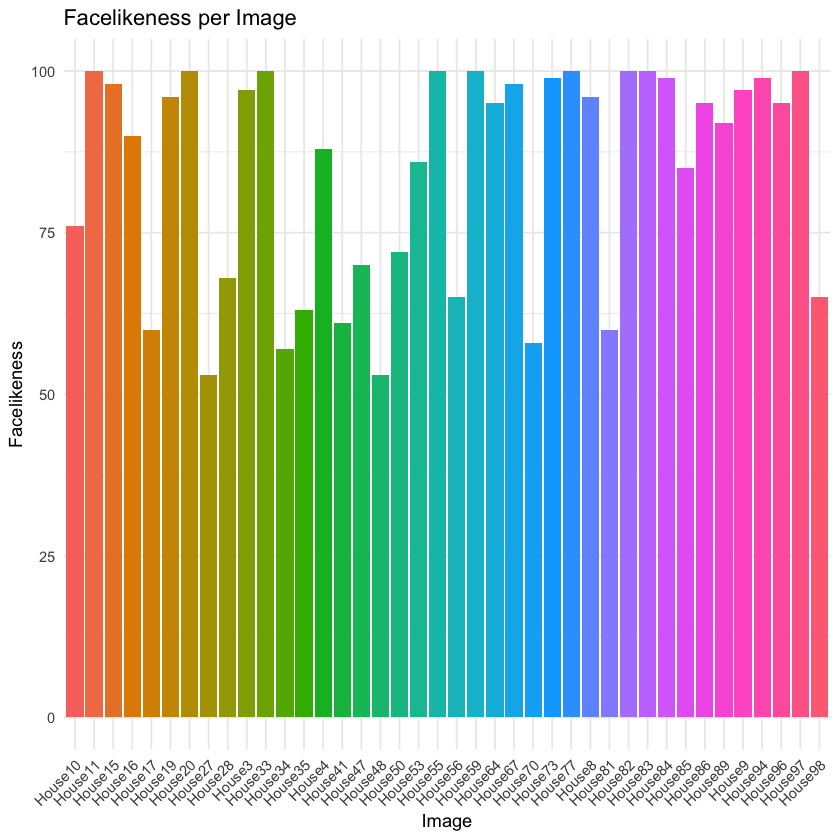

In [34]:
# ok lets plot bars per each image for facelikeness

p1 <- ggplot(rating_df, aes(x = Image, y = Facelikeness, fill = Image)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  # mean and SD
  #geom_errorbar(
  #              width = 0.2, position = position_dodge(0.9)) +
  theme_minimal() +
  labs(title = "Facelikeness per Image", x = "Image", y = "Facelikeness",) +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
  # legend off
  theme(legend.position = "none")  # Position the legend on the right +
  

# Show the plot
print(p1)


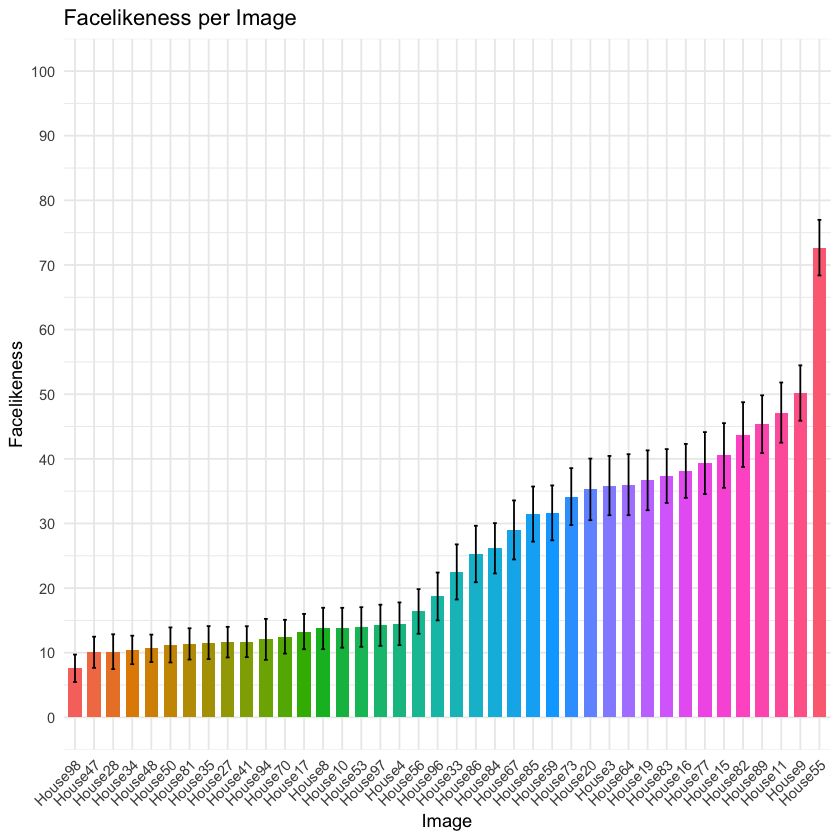

In [39]:
# Calculate summary statistics
summary_stats <- rating_df %>%
  group_by(Image) %>%
  summarise(
    mean_facelikeness = mean(Facelikeness, na.rm = TRUE),
    se_facelikeness = sd(Facelikeness, na.rm = TRUE) / sqrt(n())
  )
# Sort by mean facelikeness
summary_stats <- summary_stats %>%
  arrange(mean_facelikeness)

# Convert Image to a factor with levels in the order of mean facelikeness
summary_stats$Image <- factor(summary_stats$Image, levels = summary_stats$Image)
# Create the bar plot with error bars
p2 <- ggplot(summary_stats, aes(x = Image, y = mean_facelikeness, fill = Image)) +
  geom_bar(stat = "identity", position = position_dodge(), width = 0.7) +
  geom_errorbar(aes(ymin = mean_facelikeness - se_facelikeness, ymax = mean_facelikeness + se_facelikeness), 
                width = 0.2, position = position_dodge(0.7)) +
  theme_minimal() +
  # continous y lab with 10 
  scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, by = 10)) +
  labs(title = "Facelikeness per Image", x = "Image", y = "Facelikeness") +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
  theme(legend.position = "none")  # Turn off the legend

# Show the plot
print(p2)

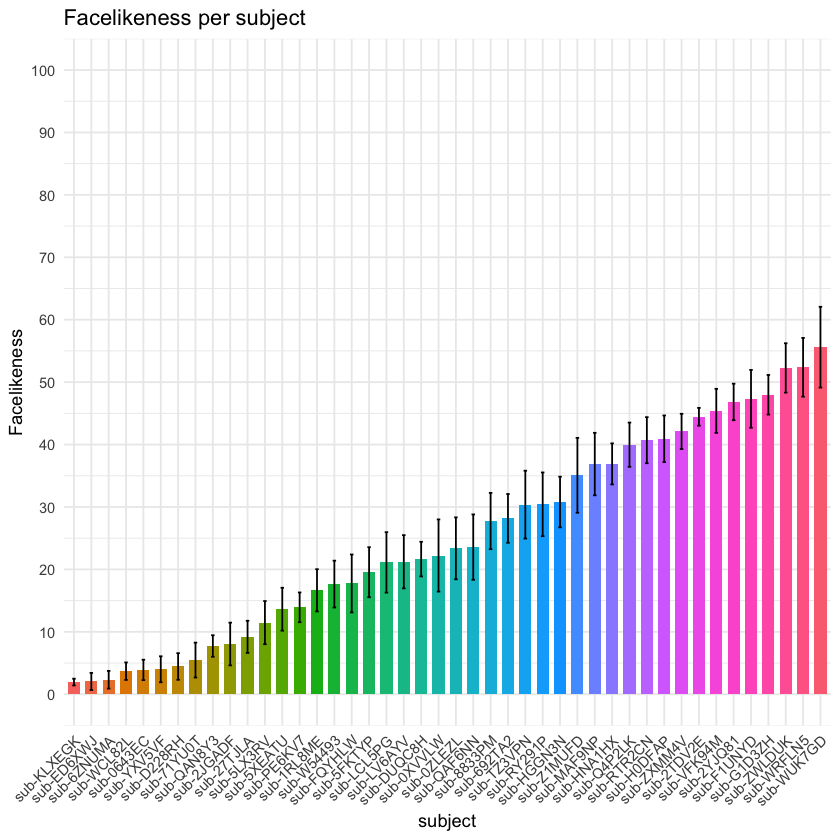

In [40]:
# Calculate summary statistics
summary_stats <- rating_df %>%
  group_by(subject) %>%
  summarise(
    mean_facelikeness = mean(Facelikeness, na.rm = TRUE),
    se_facelikeness = sd(Facelikeness, na.rm = TRUE) / sqrt(n())
  )
# Sort by mean facelikeness
summary_stats <- summary_stats %>%
  arrange(mean_facelikeness)

# Convert Image to a factor with levels in the order of mean facelikeness
summary_stats$subject <- factor(summary_stats$subject, levels = summary_stats$subject)
# Create the bar plot with error bars
p3 <- ggplot(summary_stats, aes(x = subject, y = mean_facelikeness, fill = subject)) +
  geom_bar(stat = "identity", position = position_dodge(), width = 0.7) +
  geom_errorbar(aes(ymin = mean_facelikeness - se_facelikeness, ymax = mean_facelikeness + se_facelikeness), 
                width = 0.2, position = position_dodge(0.7)) +
  theme_minimal() +
  # continous y lab with 10 
  scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, by = 10)) +
  labs(title = "Facelikeness per subject", x = "subject", y = "Facelikeness") +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
  theme(legend.position = "none")  # Turn off the legend

# Show the plot
print(p3)

# Anthropomorphism

In [8]:
mean(anthropometric_data$mean_values)
max(anthropometric_data$mean_values)
min(anthropometric_data$mean_values)

[1] 3.980247

[1] 6.666667

[1] 0.6666667

In [9]:
# classify the subjects into high and low anthropmorthism based on the mean_values

# Calculate the mean of mean_values
mean_mean_values <- mean(anthropometric_data$mean_values)

# Classify subjects as high or low anthropomorphism based on the mean_values
anthropometric_data$anthropomorphism <- ifelse(anthropometric_data$mean_values > 4.98, "High", "Low")

In [10]:
# Merge the anthropomorphism classification with the rating data
rating_df <- merge(rating_df, anthropometric_data[, c("subject", "anthropomorphism")], by = "subject")
head(rating_df)

subject    X  Image   Preference Naturalness Facelikeness ApAv Stress
1 sub-0643EC 34 House59 56         87           0           58   27    
2 sub-0643EC  0 House94 56         96           0           89   11    
3 sub-0643EC  1 House4  45         95           0           50   14    
4 sub-0643EC  2 House81 59         59           0           50   12    
5 sub-0643EC  3 House56 41         84          14           32   35    
6 sub-0643EC  4 House83 32         74          36           29   39    
  Relaxation House ⋯ ANT5 ANT6 ANT7 ANT8 ANT9 mean_values ANT_dim1 ANT_dim2
1 46         59    ⋯ 2    9    8    0    9    4.444444    2        8.666667
2 89         94    ⋯ 2    9    8    0    9    4.444444    2        8.666667
3 86         4     ⋯ 2    9    8    0    9    4.444444    2        8.666667
4 88         81    ⋯ 2    9    8    0    9    4.444444    2        8.666667
5 65         56    ⋯ 2    9    8    0    9    4.444444    2        8.666667
6 50         83    ⋯ 2    9    8    0    9    4.444444    2        8.666667
  ANT_dim3 anthropomorphism
1 2.666667 Low             
2 2.666667 Low             
3 2.666667 Low             
4 2.666667 Low             
5 2.666667 Low             
6 2.666667 Low

`summarise()` has grouped output by 'subject'. You can override using the
`.groups` argument.


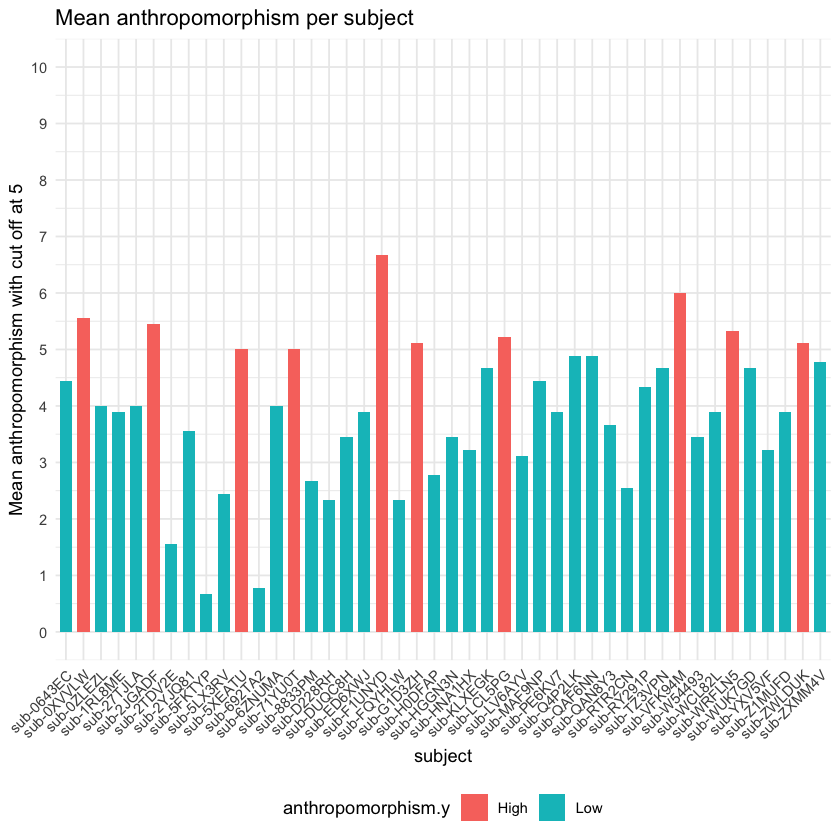

In [26]:
# create summary of mean_values by subject and anthropomorphism

summary_stats <- rating_df %>%
  group_by(subject, anthropomorphism.y) %>%
  summarise(
    mean_facelikeness = mean(mean_values, na.rm = TRUE)
  )

#plot
p_anth <- ggplot(summary_stats, aes(x = subject, y = mean_facelikeness, fill = anthropomorphism.y)) +
  geom_bar(stat = "identity", position = position_dodge(), width = 0.7) +
  theme_minimal() +
  # continous y lab with 10 
  scale_y_continuous(limits = c(0, 10), breaks = seq(0, 10, by = 1)) +
  labs(title = "Mean anthropomorphism per subject", x = "subject", y = "Mean anthropomorphism with cut off at 5") +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
  theme(legend.position = "bottom")  # Turn off the legend

p_anth

`summarise()` has grouped output by 'Image'. You can override using the
`.groups` argument.


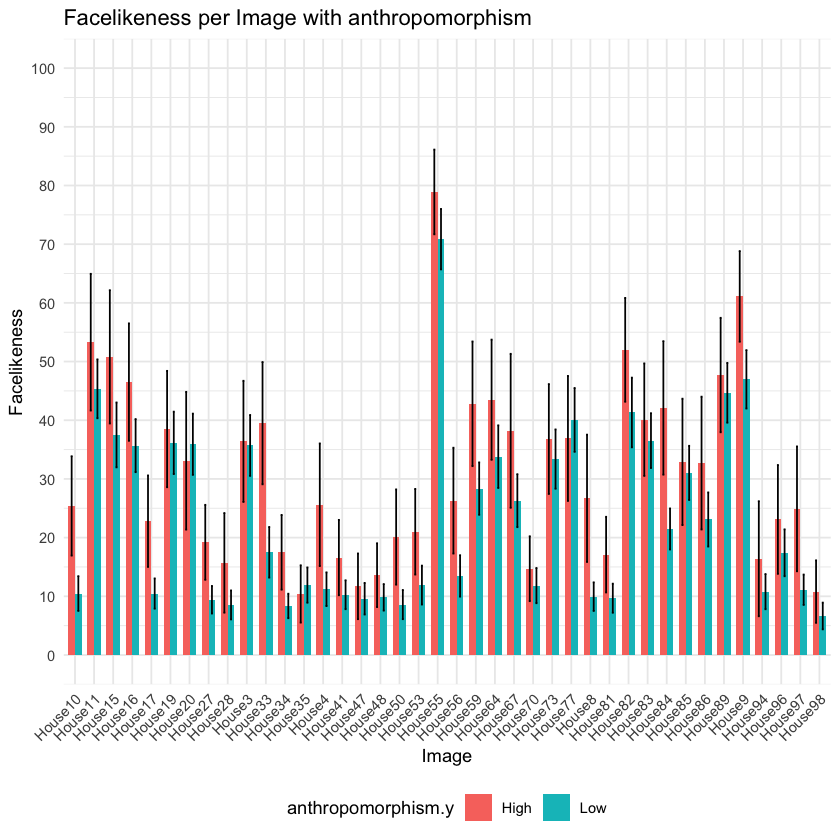

In [30]:
# plot facelikeness per image with anthropomorphism as color 

summary_stats <- rating_df %>%
  group_by(Image, anthropomorphism.y) %>%
  summarise(
    mean_facelikeness = mean(Facelikeness, na.rm = TRUE),
    se_facelikeness = sd(Facelikeness, na.rm = TRUE) / sqrt(n())
  )

# sort by mean facelikeness
summary_stats <- summary_stats %>%
  arrange(mean_facelikeness)

# convert Image to a factor with levels in the order of mean facelikeness
# summary_stats$Image <- factor(summary_stats$Image, levels = summary_stats$Image)

# plot
p_anth_image <- ggplot(summary_stats, aes(x = Image, y = mean_facelikeness, fill = anthropomorphism.y)) +
  geom_bar(stat = "identity", position = position_dodge(), width = 0.7) +
  geom_errorbar(aes(ymin = mean_facelikeness - se_facelikeness, ymax = mean_facelikeness + se_facelikeness), 
                width = 0.2, position = position_dodge(0.7)) +
  theme_minimal() +
  # continous y lab with 10 
  scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, by = 10)) +
  labs(title = "Facelikeness per Image with anthropomorphism", x = "Image", y = "Facelikeness") +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
  theme(legend.position = "bottom")  # Turn off the legend

p_anth_image

In [ ]:
# model Facelikeness ~ anthropomorphism + (1 | subject) + (1 | Image)

# relevel to high facelike
rating_df$anthropomorphism.y = as.factor(rating_df$anthropomorphism.y)
rating_df$anthropomorphism.y = relevel(rating_df$anthropomorphism.y, ref = "Low")

model_0 <- lmer(Facelikeness ~ (1 | subject) + (1 | Image), data = rating_df)

model_anthropo <- lmer(Facelikeness ~ anthropomorphism.y + (1 | subject) + (1 | Image), data = rating_df)

model_2 <- lmer(Facelikeness ~ Preference  * anthropomorphism.y + (1 | subject) + (1 | Image), data = rating_df)

model_3 <- lmer(Facelikeness ~ Preference  * ApAv * anthropomorphism.y + (1 | subject) + (1 | Image), data = rating_df)

tab_model(model_0, model_anthropo, model_2, model_3, show.reflvl = TRUE) #, file = paste0(tables, "lme_model_anthropo.html"))

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”


`summarise()` has grouped output by 'Image'. You can override using the
`.groups` argument.


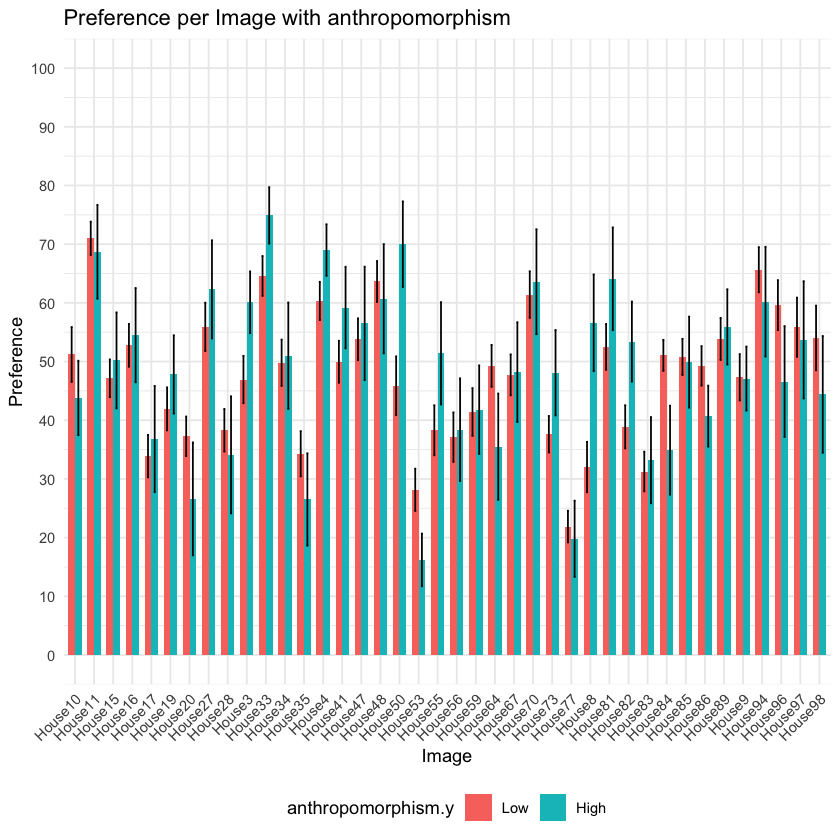

In [51]:
summary_stats <- rating_df %>%
  group_by(Image, anthropomorphism.y) %>%
  summarise(
    mean_facelikeness = mean(Preference, na.rm = TRUE),
    se_facelikeness = sd(Preference, na.rm = TRUE) / sqrt(n())
  )

# sort by mean facelikeness
summary_stats <- summary_stats %>%
  arrange(mean_facelikeness)

# convert Image to a factor with levels in the order of mean facelikeness
# summary_stats$Image <- factor(summary_stats$Image, levels = summary_stats$Image)

# plot
p_anth_image <- ggplot(summary_stats, aes(x = Image, y = mean_facelikeness, fill = anthropomorphism.y)) +
  geom_bar(stat = "identity", position = position_dodge(), width = 0.7) +
  geom_errorbar(aes(ymin = mean_facelikeness - se_facelikeness, ymax = mean_facelikeness + se_facelikeness), 
                width = 0.2, position = position_dodge(0.7)) +
  theme_minimal() +
  # continous y lab with 10 
  scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, by = 10)) +
  labs(title = "Preference per Image with anthropomorphism", x = "Image", y = "Preference") +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
  theme(legend.position = "bottom")  # Turn off the legend

p_anth_image

`summarise()` has grouped output by 'Image'. You can override using the
`.groups` argument.


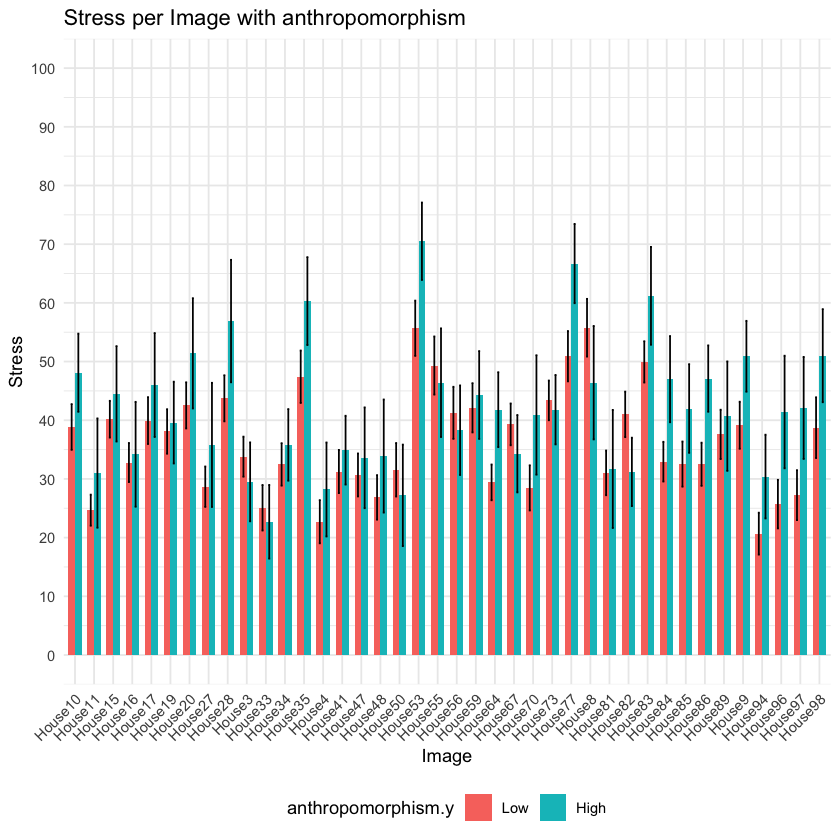

In [52]:
summary_stats <- rating_df %>%
  group_by(Image, anthropomorphism.y) %>%
  summarise(
    mean_facelikeness = mean(Stress, na.rm = TRUE),
    se_facelikeness = sd(Stress, na.rm = TRUE) / sqrt(n())
  )

# sort by mean facelikeness
summary_stats <- summary_stats %>%
  arrange(mean_facelikeness)

# convert Image to a factor with levels in the order of mean facelikeness
# summary_stats$Image <- factor(summary_stats$Image, levels = summary_stats$Image)

# plot
p_anth_image <- ggplot(summary_stats, aes(x = Image, y = mean_facelikeness, fill = anthropomorphism.y)) +
  geom_bar(stat = "identity", position = position_dodge(), width = 0.7) +
  geom_errorbar(aes(ymin = mean_facelikeness - se_facelikeness, ymax = mean_facelikeness + se_facelikeness), 
                width = 0.2, position = position_dodge(0.7)) +
  theme_minimal() +
  # continous y lab with 10 
  scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, by = 10)) +
  labs(title = "Stress per Image with anthropomorphism", x = "Image", y = "Stress") +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
  theme(legend.position = "bottom")  # Turn off the legend

p_anth_image

`summarise()` has grouped output by 'Image'. You can override using the
`.groups` argument.


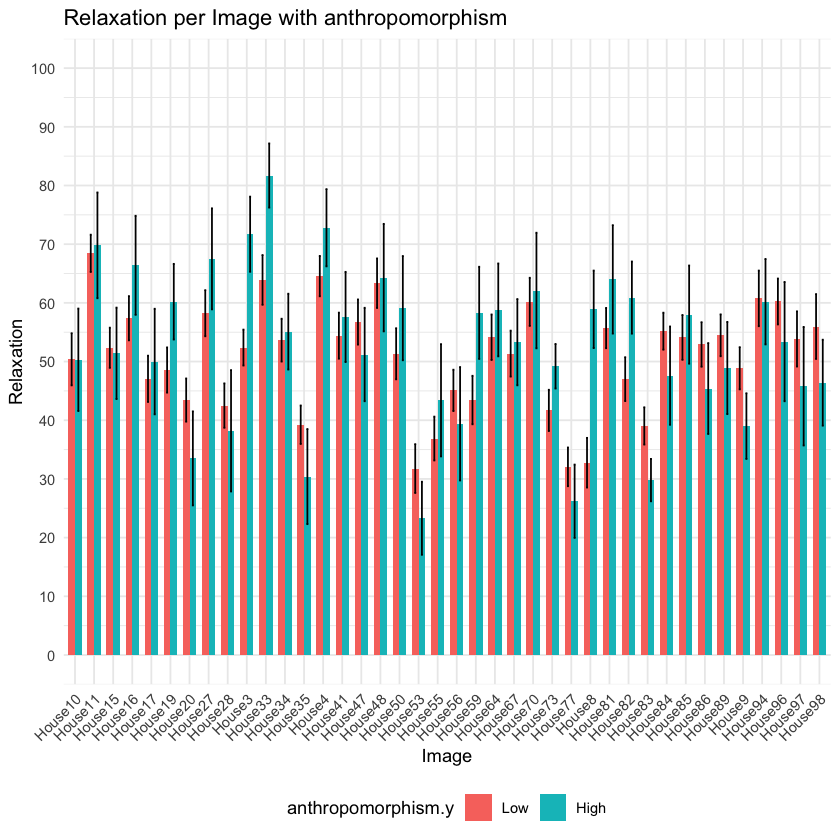

In [53]:
summary_stats <- rating_df %>%
  group_by(Image, anthropomorphism.y) %>%
  summarise(
    mean_facelikeness = mean(Relaxation, na.rm = TRUE),
    se_facelikeness = sd(Relaxation, na.rm = TRUE) / sqrt(n())
  )

# sort by mean facelikeness
summary_stats <- summary_stats %>%
  arrange(mean_facelikeness)

# convert Image to a factor with levels in the order of mean facelikeness
# summary_stats$Image <- factor(summary_stats$Image, levels = summary_stats$Image)

# plot
p_anth_image <- ggplot(summary_stats, aes(x = Image, y = mean_facelikeness, fill = anthropomorphism.y)) +
  geom_bar(stat = "identity", position = position_dodge(), width = 0.7) +
  geom_errorbar(aes(ymin = mean_facelikeness - se_facelikeness, ymax = mean_facelikeness + se_facelikeness), 
                width = 0.2, position = position_dodge(0.7)) +
  theme_minimal() +
  # continous y lab with 10 
  scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, by = 10)) +
  labs(title = "Relaxation per Image with anthropomorphism", x = "Image", y = "Relaxation") +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
  theme(legend.position = "bottom")  # Turn off the legend

p_anth_image

In [ ]:
# anova 
anova_res <- aov(Facelikeness ~ anthropomorphism.y, rating_df)
summary(anova_res)
# multiple comparisons
# Tukey's HSD test
# Perform Tukey's HSD test
tukey_results <- TukeyHSD(anova_res)
print(tukey_results)

                     Df  Sum Sq Mean Sq F value   Pr(>F)    
anthropomorphism.y    1   21085   21085   25.92 3.93e-07 ***
Residuals          1758 1429858     813                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Facelikeness ~ anthropomorphism.y, data = rating_df)

$anthropomorphism.y
             diff      lwr      upr p adj
High-Low 8.259265 5.077698 11.44083 4e-07



In [50]:
anova_pre <- aov(Preference ~ anthropomorphism.y, rating_df)
summary(anova_pre)

anova_apav <- aov(ApAv ~ anthropomorphism.y, rating_df)
summary(anova_apav)

anova_natur <- aov(Naturalness ~ anthropomorphism.y, rating_df)
summary(anova_natur)

anova_stress <- aov(Stress ~ anthropomorphism.y, rating_df)
summary(anova_stress)

anova_relax <- aov(Relaxation ~ anthropomorphism.y, rating_df)
summary(anova_relax)



                     Df  Sum Sq Mean Sq F value Pr(>F)
anthropomorphism.y    1     538   537.6   0.846  0.358
Residuals          1758 1117029   635.4               

                     Df Sum Sq Mean Sq F value Pr(>F)
anthropomorphism.y    1      1     0.8   0.002  0.969
Residuals          1758 959293   545.7               

                     Df  Sum Sq Mean Sq F value Pr(>F)
anthropomorphism.y    1     563   563.3   0.944  0.331
Residuals          1758 1048554   596.4               

                     Df  Sum Sq Mean Sq F value   Pr(>F)    
anthropomorphism.y    1    9846    9846    16.1 6.26e-05 ***
Residuals          1758 1075004     611                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                     Df  Sum Sq Mean Sq F value Pr(>F)
anthropomorphism.y    1     897   897.1   1.465  0.226
Residuals          1758 1076377   612.3               

In [57]:
# 
library(ez)

# Perform ANOVA
anova_res <- ezANOVA(
  data = rating_df,
  dv = .(Facelikeness),
  wid = .(subject),
  between = .(anthropomorphism.y),
  detailed = TRUE
)

# Print the ANOVA results
print(anova_res)

Warning message:
“Converting "subject" to factor for ANOVA.”
Warning message:
“Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”
Coefficient covariances computed by hccm()



$ANOVA
              Effect DFn DFd      SSn      SSd        F         p p<.05
1 anthropomorphism.y   1  42 527.1194 10953.09 2.021258 0.1624943      
        ges
1 0.0459155

$`Levene's Test for Homogeneity of Variance`
  DFn DFd      SSn      SSd       F          p p<.05
1   1  42 170.6207 2409.532 2.97405 0.09196327      



Warning message in geom_boxplot(width = 0.1, guides = FALSE, outlier.shape = NA, :
“Ignoring unknown parameters: `guides`”


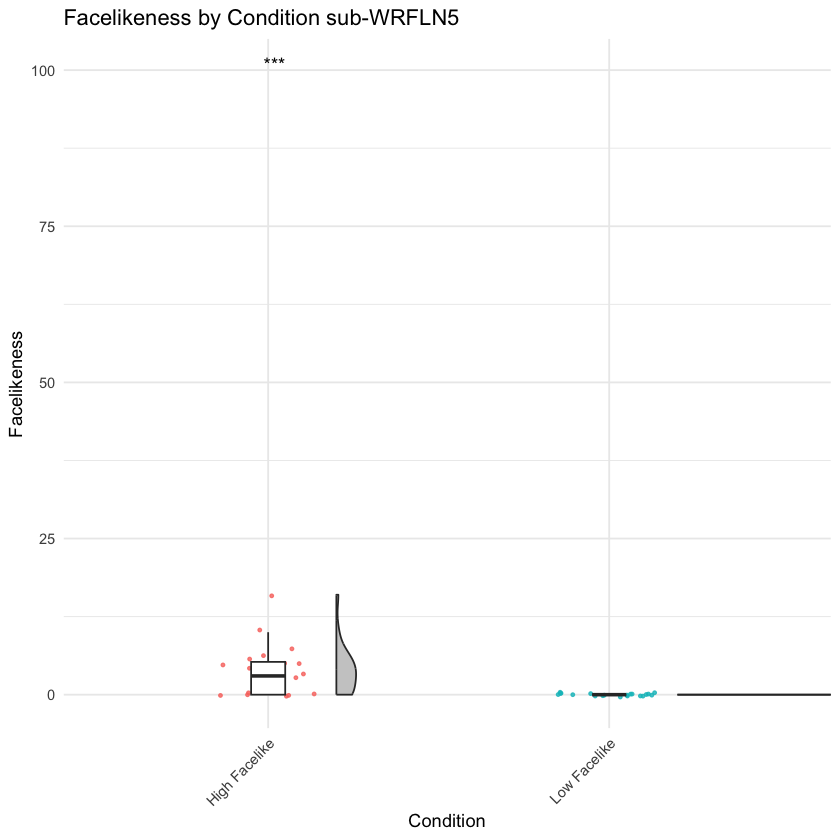

In [31]:
# select sub-KLXEGK only from the data

sub <- subset(rating_df, subject == 'sub-KLXEGK')

#sub-KLXEGK
# sub-ED6XWJ
#sub-WUK7GD

# plot like plot the preference naturalness and facelikeness, apav, stress, relaxation (one plot for each)

# raincloud plot

# Create the raincloud plot
rain <- ggplot(sub, aes(x = Condition, y = Facelikeness, fill = Condition)) +
  geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8, fill = "gray") +
  geom_point(aes(color = Condition), position = position_jitter(width = .15), size = .7, alpha = 0.8) +
  geom_boxplot(width = .1, guides = FALSE, outlier.shape = NA, fill = "white") +
  # compare
    stat_compare_means(method = "t.test", label = "p.signif", label.y = 100) +
  theme_minimal() +
  labs(title = "Facelikeness by Condition sub-WRFLN5",
       x = "Condition",
       y = "Facelikeness") +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
  theme(legend.position = "none")  # Turn off the legend

# Show the plot
print(rain)

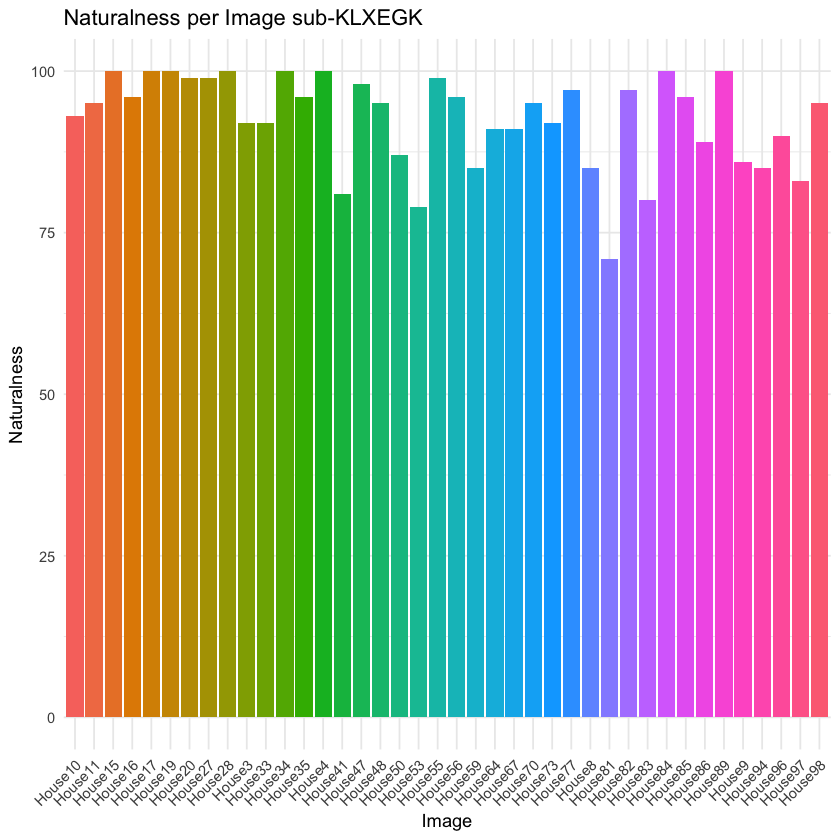

In [39]:
# sub Facelikeness by image bar

p1 <- ggplot(sub, aes(x = Image, y = Naturalness, fill = Image)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  # mean and SD
  #geom_errorbar(
  #              width = 0.2, position = position_dodge(0.9)) +
  theme_minimal() +
  labs(title = "Naturalness per Image sub-KLXEGK", x = "Image", y = "Naturalness",) +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
  # legend off
  theme(legend.position = "none")  # Position the legend on the right +

# Show the plot
print(p1)

# Model

In [25]:
model_0 <- lmer(Facelikeness ~ Preference + (1 | subject) + (1 | Image), data = rating_df)

model_1 <- lmer(Facelikeness ~ Preference + Naturalness + (1 | subject) + (1 | Image), data = rating_df)

tab_model(model_0,model_1, show.reflvl = TRUE) #, file = paste0(tables, "lme_model_facelikeness.html"))

In [198]:
# Load necessary library
library(car)

# Check for multicollinearity
vif(lm(Dim1 ~ Preference + Naturalness + Facelikeness + ApAv + Stress + Relaxation, data = rating_df))

Preference  Naturalness Facelikeness         ApAv       Stress   Relaxation 
    2.702900     1.622908     1.026019     3.553840     2.185618     2.446385

In [ ]:
# Which rating predicts the Dimension 1 and 2

# Fit a linear model for each rating scale
# Extract the summary of the model
model_allratingsD1 <- lm(Dim1 ~ Preference + Naturalness + Facelikeness + ApAv + Stress + Relaxation, data = rating_df)
model_summary <- summary(model_allratingsD1)
# Convert coefficients to a data frame
coefficients_df <- as.data.frame(model_summary$coefficients)
# Add meaningful column names
names(coefficients_df) <- c("Estimate", "Std. Error", "t value", "Pr(>|t|)")
# Use kable to display the coefficients in Markdown format
knitr::kable(coefficients_df, format = "markdown", caption = "Linear Model Summary for Dimension 1")


model_allratingsD2 <- lm(Dim2 ~ Preference + Naturalness + Facelikeness + ApAv + Stress + Relaxation, data = rating_df)
tab_model(model_allratingsD2)
model_summary <- summary(model_allratingsD2)
# Convert coefficients to a data frame
coefficients_df <- as.data.frame(model_summary$coefficients)
# Add meaningful column names
names(coefficients_df) <- c("Estimate", "Std. Error", "t value", "Pr(>|t|)")
# Use kable to display the coefficients in Markdown format
knitr::kable(coefficients_df, format = "markdown", caption = "Linear Model Summary for Dimension 2")


In [199]:
colnames(rating_df)

[1] "subject"      "X"            "Image"        "Preference"   "Naturalness" 
 [6] "Facelikeness" "ApAv"         "Stress"       "Relaxation"   "House"       
[11] "Condition"    "Dim1"         "Dim2"         "Dim3"         "ANT1"        
[16] "ANT2"         "ANT3"         "ANT4"         "ANT5"         "ANT6"        
[21] "ANT7"         "ANT8"         "ANT9"         "mean_values"

In [183]:
# turn image into a factor
rating_df$Image = as.factor(rating_df$Image)


In [201]:
# Fit the same model with subject as a random effect

#LMER is overfitting the data, so I will use LM
# model_d1 <- lmer(Dim1 ~ Preference + Naturalness + Facelikeness + ApAv + Stress + Relaxation + (1|subject), data = rating_df)
# model_d2 <- lmer(Dim2 ~ Preference + Naturalness + Facelikeness + ApAv + Stress + Relaxation + (1|subject), data = rating_df)
# model_d3 <- lmer(Dim3 ~ Preference + Naturalness + Facelikeness + ApAv + Stress + Relaxation + (1|subject), data = rating_df)

model_d1 <- lm(Dim1 ~ Preference + Naturalness + Facelikeness + ApAv + Stress + Relaxation, data = rating_df)
model_d2 <- lm(Dim2 ~ Preference + Naturalness + Facelikeness + ApAv + Stress + Relaxation, data = rating_df)
model_d3 <- lm(Dim3 ~ Preference + Naturalness + Facelikeness + ApAv + Stress + Relaxation, data = rating_df)


tab_model(model_d1,model_d2,model_d3, show.reflvl = TRUE, file = paste0(tables, "lm_model_mds.html"))

#### What predicts facelikeness?

The correlation heatmap reveals strong relationships among perceptual and emotional variables, particularly highlighting the connection between Facelikeness, Preference, and Relaxation. Items rated as more facelike tend to be more preferred (r>0.8) and associated with higher levels of relaxation (r>0.7), suggesting a shared underlying positive evaluation. Additionally, Facelikeness is moderately negatively correlated with Stress (r<−0.4), indicating that facelike features may contribute to a calming effect. Naturalness shows a moderate positive correlation with Relaxation, emphasizing its role in fostering a sense of ease, while Preference is moderately aligned with Approach-Avoidance tendencies, reflecting the connection between liking and action-oriented responses. The statistical significance of most relationships underscores the consistent and meaningful associations between these variables, offering insights into how perceptual qualities shape emotional and evaluative judgments.

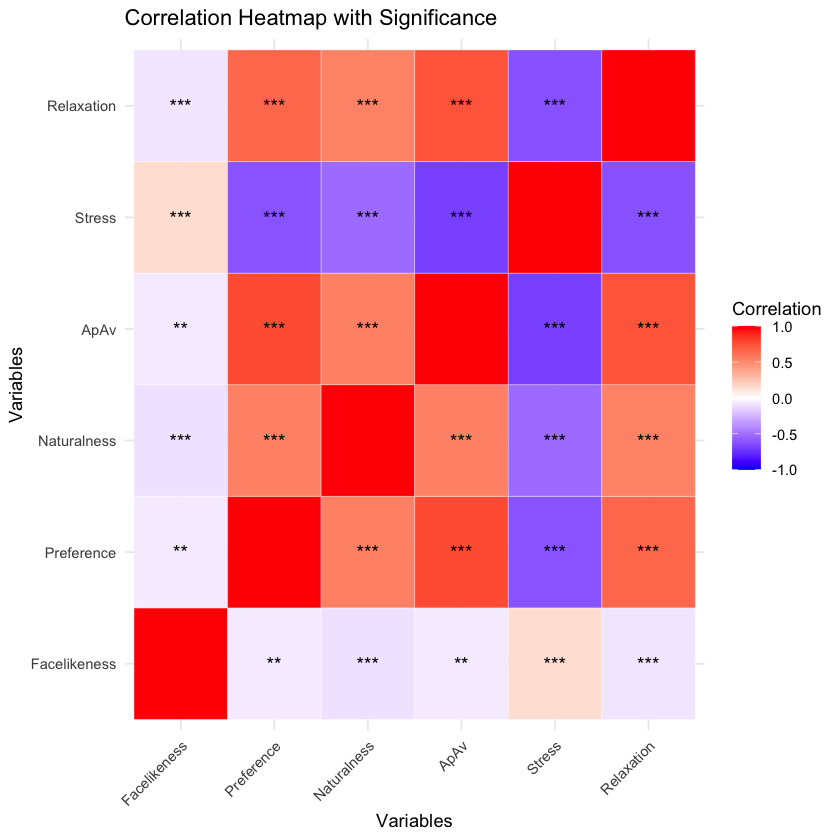



But what explains the ratings of facelikeness of the scene? 

LME? 

In [ ]:
# What predicts face likeness

# correlate the ratings with the face likeness
correlation = cor(rating_df[,c('Facelikeness', 'Preference', 'Naturalness', 'ApAv', 'Stress', 'Relaxation')], use = "complete.obs")

# Convert the correlation matrix to a data frame
correlation_df <- as.data.frame(correlation)

# Use kable to display the correlation matrix in Markdown format
knitr::kable(correlation_df, format = "markdown", caption = "Correlation Matrix of Ratings with Face Likeness")


In [ ]:
# What

# Supplementary:

In [ ]:
# do a quick check of the data with ANOVA to see if there are any differences between the conditions

# rating_df$Condition = as.factor(rating_df$Condition)
# rating_df$House = as.factor(rating_df$House)
# rating_df$Subject = as.factor(rating_df$subject)
# # run an ANOVA for face likeness
# aov_face = anova(lm(Facelikeness ~ Condition, data = rating_df))
# # knit the results
# kable(aov_face)
# plot the data
ggplot(rating_df, aes(x = Condition, y = Facelikeness)) +
    # add the raincloud plot
    geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8, fill = "gray") +
    geom_point(aes(color = Condition), position = position_jitter(width = .15), size = .5, alpha = 0.8) +
    geom_boxplot(width = .1, guides = FALSE, outlier.shape = NA, fill = "white") +
    geom_jitter(aes(color = Condition), width = .2, alpha = .8) +
    scale_colour_brewer(palette = "Accent") +
    scale_fill_brewer(palette = "Accent") +
    coord_flip() +
    theme_apa()  +
    scale_y_continuous(breaks = seq(0, 100, by = 10)) + 
    labs(title = paste("sample = ", n_subjects, " subjects"))

# save the plot
ggsave(paste0(figures, "Facelikeness_plot.png"), width = 6, height = 4, dpi = 300)

# Preference

# # run an ANOVA for face likeness
# aov_face = anova(lm(Preference ~ Condition, data = rating_df))
# # knit the results
# kable(aov_face)
# plot the data
ggplot(rating_df, aes(x = Condition, y = Preference)) +
    # add the raincloud plot
    geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8, fill = "gray") +
    geom_point(aes(color = Condition), position = position_jitter(width = .15), size = .5, alpha = 0.8) +
    geom_boxplot(width = .1, guides = FALSE, outlier.shape = NA, fill = "white") +
    geom_jitter(aes(color = Condition), width = .2, alpha = .8) +
    scale_colour_brewer(palette = "Accent") +
    scale_fill_brewer(palette = "Accent") +
    coord_flip() +
    theme_apa()  +
    scale_y_continuous(breaks = seq(0, 100, by = 10)) +
    labs(title = paste("sample = ", n_subjects, " subjects"))

# save the plot

# Naturalness

# # run an ANOVA for face likeness
# aov_face = anova(lm(Naturalness ~ Condition, data = rating_df))
# # knit the results
# kable(aov_face)
# plot the data
ggplot(rating_df, aes(x = Condition, y = Naturalness)) +
    # add the raincloud plot
    geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8, fill = "gray") +
    geom_point(aes(color = Condition), position = position_jitter(width = .15), size = .5, alpha = 0.8) +
    geom_boxplot(width = .1, guides = FALSE, outlier.shape = NA, fill = "white") +
    geom_jitter(aes(color = Condition), width = .2, alpha = .8) +
    scale_colour_brewer(palette = "Accent") +
    scale_fill_brewer(palette = "Accent") +
    coord_flip() +
    theme_apa()  +
    scale_y_continuous(breaks = seq(0, 100, by = 10)) +
    labs(title = paste("sample = ", n_subjects, " subjects"))

# save the plot
ggsave(paste0(figures, "Naturalness_plot.png"), width = 6, height = 4, dpi = 300)

# ApAv

# # run an ANOVA for face likeness
# aov_face = anova(lm(ApAv ~ Condition, data = rating_df))
# # knit the results
# kable(aov_face)
# plot the data
ggplot(rating_df, aes(x = Condition, y = ApAv)) +
    # add the raincloud plot
    geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8, fill = "gray") +
    geom_point(aes(color = Condition), position = position_jitter(width = .15), size = .5, alpha = 0.8) +
    geom_boxplot(width = .1, guides = FALSE, outlier.shape = NA, fill = "white") +
    geom_jitter(aes(color = Condition), width = .2, alpha = .8) +
    scale_colour_brewer(palette = "Accent") +
    scale_fill_brewer(palette = "Accent") +
    coord_flip() +
    theme_apa()  +
    scale_y_continuous(breaks = seq(0, 100, by = 10)) +
    labs(title = paste("sample = ", n_subjects, " subjects")) 

# save the plot
ggsave(paste0(figures, "ApAv_plot.png"), width = 6, height = 4, dpi = 300)

# Stress
# # run an ANOVA for face likeness
# aov_face = anova(lm(Stress ~ Condition, data = rating_df))
# # knit the results
# kable(aov_face)
# plot the data
ggplot(rating_df, aes(x = Condition, y = Stress)) +
    # add the raincloud plot
    geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8, fill = "gray") +
    geom_point(aes(color = Condition), position = position_jitter(width = .15), size = .5, alpha = 0.8) +
    geom_boxplot(width = .1, guides = FALSE, outlier.shape = NA, fill = "white") +
    geom_jitter(aes(color = Condition), width = .2, alpha = .8) +
    scale_colour_brewer(palette = "Accent") +
    scale_fill_brewer(palette = "Accent") +
    coord_flip() +
    theme_apa()  +
    scale_y_continuous(breaks = seq(0, 100, by = 10)) +
    labs(title = paste("sample = ", n_subjects, " subjects"))

# save the plot
ggsave(paste0(figures, "Stress_plot.png"), width = 6, height = 4, dpi = 300)

# relaxation
# # run an ANOVA for face likeness
# aov_face = anova(lm(Relaxation ~ Condition, data = rating_df))
# # knit the results
# kable(aov_face)
# plot the data
ggplot(rating_df, aes(x = Condition, y = Relaxation)) +
    # add the raincloud plot
    geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8, fill = "gray") +
    geom_point(aes(color = Condition), position = position_jitter(width = .15), size = .5, alpha = 0.8) +
    geom_boxplot(width = .1, guides = FALSE, outlier.shape = NA, fill = "white") +
    geom_jitter(aes(color = Condition), width = .2, alpha = .8) +
    scale_colour_brewer(palette = "Accent") +
    scale_fill_brewer(palette = "Accent") +
    coord_flip() +
    theme_apa()  +
    scale_y_continuous(breaks = seq(0, 100, by = 10)) +
    labs(title = paste("sample = ", n_subjects, " subjects")) 

# save the plot
ggsave(paste0(figures, "Relaxation_plot.png"), width = 6, height = 4, dpi = 300)

In [ ]:
library(Rtsne)

# Perform t-SNE (t-Distributed Stochastic Neighbor Embedding )
tsne_result <- Rtsne(ssat_sum_numeric, dims = 2, perplexity = 10)

# Extract the t-SNE coordinates
tsne_coords <- tsne_result$Y

# Convert the coordinates to a data frame for easier handling
tsne_df <- as.data.frame(tsne_coords)
colnames(tsne_df) <- c("Dim1", "Dim2")
tsne_df$image <- column_names  # Add image names

# Plot the t-SNE results with labels
ggplot(tsne_df, aes(x = Dim1, y = Dim2)) +
  geom_point(aes(color = details$Condition)) +
  geom_text(aes(label = column_names), vjust = -0.5, hjust = 0.5) +
  theme_minimal() +
  labs(title = "t-SNE of SSAT Data",
       x = "Dimension 1",
       y = "Dimension 2")


In [ ]:
# PCA 

# Perform PCA
pca_result <- prcomp(ssat_sum_numeric, scale. = TRUE)

# Extract the PCA coordinates (scores)
pca_coords <- pca_result$x

# Convert the coordinates to a data frame for easier handling
pca_df <- as.data.frame(pca_coords)
colnames(pca_df) <- c("PC1", "PC2", "PC3", "PC4")  # Adjust as needed for more PCs

# Assuming column_names contains the image names
pca_df$image <- column_names # Remove the first element which is the row/column label

# Print the PCA results
#print(pca_df)

# Plot the PCA results with labels for the first two principal components
ggplot(pca_df, aes(x = PC1, y = PC2)) +
  geom_point(aes(color = details$Condition)) +
  geom_text(aes(label = column_names), vjust = -0.5, hjust = 0.5) +
  theme_minimal() +
  labs(title = "PCA of SSAT Data",
       x = "Principal Component 1",
       y = "Principal Component 2")

# Plot explained variance
explained_variance <- pca_result$sdev^2 / sum(pca_result$sdev^2) * 100
explained_variance_df <- data.frame(PC = paste0("PC", 1:length(explained_variance)),
                                    ExplainedVariance = explained_variance)

ggplot(explained_variance_df, aes(x = PC, y = ExplainedVariance)) +
  geom_bar(stat = "identity") +
  # turn the x-axis labels sideways
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(title = "Explained Variance by Principal Components",
       x = "Principal Components",
       y = "Explained Variance (%)")


# Modelling 

In [ ]:
# Add the PCA scores to the ratings data frame
rating_df$PC1 <- pca_df$PC1
# mds_df add this to rating_df
rating_df$Dim1 <- mds_df$Dim1
rating_df$Dim2 <- mds_df$Dim2

In [ ]:
# load Anthropometric data
anthropometric_data = read.csv('Anth_covariate.csv',header = TRUE, sep = ",")

#add 'sub-'' to subject id
anthropometric_data$subject = paste0('sub-',anthropometric_data$subject)

# Calculate the mean of columns 2 to 10 for each row
anthropometric_data$mean_values <- rowMeans(anthropometric_data[, 2:10], na.rm = TRUE)

# average anthropometric data for each subject
#anthropometric_data$mean = aggregate(anthropometric_data, by = list(anthropometric_data$subject), FUN = mean)


# merge the ratings with the mean anthropometric data
rating_df = merge(rating_df, anthropometric_data, by = 'subject')


In [ ]:
# reverse ApAv coding   

rating_df$ApAv = 100 - rating_df$ApAv

In [ ]:
# facelikeness over mean values of anthropometric data)
model0 <- lmer(Facelikeness ~ mean_values + (1|subject), data = rating_df)
tab_model(model0)

# Facelikeness over all other ratings (here naturalness and stress come out)
model1 <- lmer(Facelikeness ~ Relaxation + Stress + ApAv + Preference + Naturalness + mean_values + (1|subject), data = rating_df)
tab_model(model1)

# Facelikeness over Reversed approach-avoidance
model2 <- lmer(Facelikeness ~ ApAv + (1|subject), data = rating_df)
tab_model(model2)

In [ ]:
# lm Facelikeness ~ ApAv  and plot it
model2 <- lm(Facelikeness ~ ApAv, data = rating_df)
tab_model(model2)

# plot the data
ggplot(rating_df, aes(x = ApAv, y = Facelikeness)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE) +
    theme_minimal() +
    labs(title = "Facelikeness ~ ApAv",
         x = "ApAv Reversed",
         y = "Facelikeness")

In [ ]:
# LMM  PC1 ~ Facelikeness + mean_values + (1|subject)

# Fit the linear mixed model
model1 <- lmer(Dim1 ~ Facelikeness + (subject), data = rating_df)

# Print the model summary
summary(model1)

# tab_model(model1)
tab_model(model1)

In [ ]:
# Check if principal components are correlated with the ratings

# Run a linear regression to check the relationship between PC1 and Facelikeness
lm_result <- lm(Facelikeness ~ PC1, data = rating_df)

# Run a linear regression to check the relationship between Dim1 and Facelikeness
lm_result_mds <- lm(Facelikeness ~ Dim1, data = rating_df)

# Print the regression results
print(summary(lm_result))
print(summary(lm_result_mds))

# Plot the relationship between PC1 and Facelikeness
ggplot(rating_df, aes(x = Facelikeness, y = PC1)) +
  geom_point(aes(color = Condition)) +
  geom_smooth(method = "lm", se = FALSE) +
  theme_minimal() +
  labs(title = "Relationship between PC1 and Facelikeness",
       x = "Facelikeness",
       y = "Principal Component 1")

# Plot the relationship between Dim1 and Facelikeness
ggplot(rating_df, aes(x = Facelikeness, y = Dim1)) +
  geom_point(aes(color = Condition)) +
  geom_smooth(method = "lm", se = FALSE) +
  theme_minimal() +
  labs(title = "Relationship between Dim1 and Facelikeness",
       x = "Facelikeness",
       y = "Dimension 1")

In [ ]:
# Run a linear regression to check the relationship between PC1 and Facelikeness
lm_result <- lm(Preference ~ PC1, data = rating_df)

# MDS D1
lm_result_mds <- lm(Preference ~ Dim1, data = rating_df)

# Print the regression results
print(summary(lm_result))
print(summary(lm_result_mds))

# Plot the relationship between PC1 and Facelikeness
ggplot(rating_df, aes(x = Preference, y = PC1)) +
  geom_point(aes(color = Condition)) +
  geom_smooth(method = "lm", se = FALSE) +
  theme_minimal() +
  labs(title = "Relationship between PC1 and Preference",
       x = "Preference",
       y = "Principal Component 1")

# Plot the relationship between Dim1 and Facelikeness
ggplot(rating_df, aes(x = Preference, y = Dim1)) +
  geom_point(aes(color = Condition)) +
  geom_smooth(method = "lm", se = FALSE) +
  theme_minimal() +
  labs(title = "Relationship between Dim1 and Preference",
       x = "Preference",
       y = "Dimension 1")

# Sandra Study

In [62]:

data <- read.csv("/Users/sztuka/Documents/ARCH2/Sandra_study/ratings_trim.csv")

colnames(data)

[1] "No"          "Prolific_ID" "Short_ID"    "Study_no"    "Pic_1_2"    
  [6] "Block_1_1"   "Block_1_2"   "Block_1_3"   "Block_1_4"   "Block_1_5"  
 [11] "Block_1_6"   "Block_1_7"   "Block_1_8"   "Block_1_9"   "Block_1_10" 
 [16] "Block_1_11"  "Block_1_12"  "Pic_2_2"     "Block_2_1"   "Block_2_2"  
 [21] "Block_2_3"   "Block_2_4"   "Block_2_5"   "Block_2_6"   "Block_2_7"  
 [26] "Block_2_8"   "Block_2_9"   "Block_2_10"  "Block_2_11"  "Block_2_12" 
 [31] "Pic_3_2"     "Block_3_1"   "Block_3_2"   "Block_3_3"   "Block_3_4"  
 [36] "Block_3_5"   "Block_3_6"   "Block_3_7"   "Block_3_8"   "Block_3_9"  
 [41] "Block_3_10"  "Block_3_11"  "Block_3_12"  "Pic_4_2"     "Block_4_1"  
 [46] "Block_4_2"   "Block_4_3"   "Block_4_4"   "Block_4_5"   "Block_4_6"  
 [51] "Block_4_7"   "Block_4_8"   "Block_4_9"   "Block_4_10"  "Block_4_11" 
 [56] "Block_4_12"  "Pic_5_2"     "Block_5_1"   "Block_5_2"   "Block_5_3"  
 [61] "Block_5_4"   "Block_5_5"   "Block_5_6"   "Block_5_7"   "Block_5_8"  
 [66] "Block_5_9"   "Block_5_10"  "Block_5_11"  "Block_5_12"  "Pic_6_2"    
 [71] "Block_6_1"   "Block_6_2"   "Block_6_3"   "Block_6_4"   "Block_6_5"  
 [76] "Block_6_6"   "Block_6_7"   "Block_6_8"   "Block_6_9"   "Block_6_10" 
 [81] "Block_6_11"  "Block_6_12"  "Pic_7_2"     "Block_7_1"   "Block_7_2"  
 [86] "Block_7_3"   "Block_7_4"   "Block_7_5"   "Block_7_6"   "Block_7_7"  
 [91] "Block_7_8"   "Block_7_9"   "Block_7_10"  "Block_7_11"  "Block_7_12" 
 [96] "Pic_8_2"     "Block_8_1"   "Block_8_2"   "Block_8_3"   "Block_8_4"  
[101] "Block_8_5"   "Block_8_6"   "Block_8_7"   "Block_8_8"   "Block_8_9"  
[106] "Block_8_10"  "Block_8_11"  "Block_8_12"  "Pic_9_2"     "Block_9_1"  
[111] "Block_9_2"   "Block_9_3"   "Block_9_4"   "Block_9_5"   "Block_9_6"  
[116] "Block_9_7"   "Block_9_8"   "Block_9_9"   "Block_9_10"  "Block_9_11" 
[121] "Block_9_12"  "Pic_10_2"    "Block_10_1"  "Block_10_2"  "Block_10_3" 
[126] "Block_10_4"  "Block_10_5"  "Block_10_6"  "Block_10_7"  "Block_10_8" 
[131] "Block_10_9"  "Block_10_10" "Block_10_11" "Block_10_12" "Pic_11_2"   
[136] "Block_11_1"  "Block_11_2"  "Block_11_3"  "Block_11_4"  "Block_11_5" 
[141] "Block_11_6"  "Block_11_7"  "Block_11_8"  "Block_11_9"  "Block_11_10"
[146] "Block_11_11" "Block_11_12" "Pic_12_2"    "Block_12_1"  "Block_12_2" 
[151] "Block_12_3"  "Block_12_4"  "Block_12_5"  "Block_12_6"  "Block_12_7" 
[156] "Block_12_8"  "Block_12_9"  "Block_12_10" "Block_12_11" "Block_12_12"
[161] "Pic_13_2"    "Block_13_1"  "Block_13_2"  "Block_13_3"  "Block_13_4" 
[166] "Block_13_5"  "Block_13_6"  "Block_13_7"  "Block_13_8"  "Block_13_9" 
[171] "Block_13_10" "Block_13_11" "Block_13_12" "Pic_14_2"    "Block_14_1" 
[176] "Block_14_2"  "Block_14_3"  "Block_14_4"  "Block_14_5"  "Block_14_6" 
[181] "Block_14_7"  "Block_14_8"  "Block_14_9"  "Block_14_10" "Block_14_11"
[186] "Block_14_12" "Pic_15_2"    "Block_15_1"  "Block_15_2"  "Block_15_3" 
[191] "Block_15_4"  "Block_15_5"  "Block_15_6"  "Block_15_7"  "Block_15_8" 
[196] "Block_15_9"  "Block_15_10" "Block_15_11" "Block_15_12" "Pic_16_2"   
[201] "Block_16_1"  "Block_16_2"  "Block_16_3"  "Block_16_4"  "Block_16_5" 
[206] "Block_16_6"  "Block_16_7"  "Block_16_8"  "Block_16_9"  "Block_16_10"
[211] "Block_16_11" "Block_16_12" "Pic_17_2"    "Block_17_1"  "Block_17_2" 
[216] "Block_17_3"  "Block_17_4"  "Block_17_5"  "Block_17_6"  "Block_17_7" 
[221] "Block_17_8"  "Block_17_9"  "Block_17_10" "Block_17_11" "Block_17_12"
[226] "Pic_18_2"    "Block_18_1"  "Block_18_2"  "Block_18_3"  "Block_18_4" 
[231] "Block_18_5"  "Block_18_6"  "Block_18_7"  "Block_18_8"  "Block_18_9" 
[236] "Block_18_10" "Block_18_11" "Block_18_12" "Pic_19_2"    "Block_19_1" 
[241] "Block_19_2"  "Block_19_3"  "Block_19_4"  "Block_19_5"  "Block_19_6" 
[246] "Block_19_7"  "Block_19_8"  "Block_19_9"  "Block_19_10" "Block_19_11"
[251] "Block_19_12" "Pic_20_2"    "Block_20_1"  "Block_20_2"  "Block_20_3" 
[256] "Block_20_4"  "Block_20_5"  "Block_20_6"  "Block_20_7"  "Block_20_8" 
[261] "Block_20_9"  "Block_20_10" "Block_20_11" "B

In [72]:
library(dplyr)

# Verify column names
print(colnames(data))

# Use base R grep with dplyr's select
selected_data <- data %>%
  select(all_of(grep("_1$|_7$", colnames(data), value = TRUE)))

# View the result
head(selected_data)


  [1] "No"          "Prolific_ID" "Short_ID"    "Study_no"    "Pic_1_2"    
  [6] "Block_1_1"   "Block_1_2"   "Block_1_3"   "Block_1_4"   "Block_1_5"  
 [11] "Block_1_6"   "Block_1_7"   "Block_1_8"   "Block_1_9"   "Block_1_10" 
 [16] "Block_1_11"  "Block_1_12"  "Pic_2_2"     "Block_2_1"   "Block_2_2"  
 [21] "Block_2_3"   "Block_2_4"   "Block_2_5"   "Block_2_6"   "Block_2_7"  
 [26] "Block_2_8"   "Block_2_9"   "Block_2_10"  "Block_2_11"  "Block_2_12" 
 [31] "Pic_3_2"     "Block_3_1"   "Block_3_2"   "Block_3_3"   "Block_3_4"  
 [36] "Block_3_5"   "Block_3_6"   "Block_3_7"   "Block_3_8"   "Block_3_9"  
 [41] "Block_3_10"  "Block_3_11"  "Block_3_12"  "Pic_4_2"     "Block_4_1"  
 [46] "Block_4_2"   "Block_4_3"   "Block_4_4"   "Block_4_5"   "Block_4_6"  
 [51] "Block_4_7"   "Block_4_8"   "Block_4_9"   "Block_4_10"  "Block_4_11" 
 [56] "Block_4_12"  "Pic_5_2"     "Block_5_1"   "Block_5_2"   "Block_5_3"  
 [61] "Block_5_4"   "Block_5_5"   "Block_5_6"   "Block_5_7"   "Block_5_8"  
 [66] "Block

ERROR: Error in select(., all_of(grep("_1$|_7$", colnames(data), value = TRUE))): unused argument (all_of(grep("_1$|_7$", colnames(data), value = TRUE)))
